In [1]:
!pip install jupyter_contrib_nbextensions -q
!jupyter contrib nbextension install --user -q

usage: jupyter-contrib [-h] [--debug] [--user] [--system] [--sys-prefix]
                       [--overwrite] [--symlink] [--skip-running-check]
                       [--perform-running-check] [-s] [--only-config]
                       [--only-files]
                       [--prefix InstallContribNbextensionsApp.prefix]
                       [--nbextensions InstallContribNbextensionsApp.nbextensions_dir]
                       [extra_args ...]
jupyter-contrib: error: argument -q: expected one argument


# Выпускной проект. Промышленность


Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.

**Цель — построить модель, которая будет определять температуру сплава**.

Заказчик хочет использовать разработанную модель для имитации технологического процесса. 

Справочная информация

*Описание процесса обработки*:

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.
Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.
Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.
Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**

таблицы СУБД Sqlite:

**steel.data_arc** — данные об электродах;
- key — номер партии;
- BeginHeat — время начала нагрева;
- EndHeat — время окончания нагрева;
- ActivePower — значение активной мощности;
- ReactivePower — значение реактивной мощности.

**steel.data_bulk** — данные об объёме сыпучих материалов;
- key — номер партии;
- Bulk1 … Bulk15 — объём подаваемого материала.

**steel.data_bulk_time** — данные о времени подачи сыпучих материалов;
- key — номер партии;
- Bulk1 … Bulk15 — время подачи материала.

**steel.data_gas** — данные о продувке сплава газом;
- key — номер партии;
- gas — объём подаваемого газа.

**steel.data_temp** — данные об измерениях температуры;
- key — номер партии;
- MesaureTime — время замера;
- Temperature — значение температуры.

**steel.data_wire** — данные об объёме проволочных материалов;
- key — номер партии;
- Wire1 … Wire9 — объём подаваемых проволочных материалов.

**steel.data_wire_time** — данные о времени подачи проволочных материалов.
- key — номер партии;
- Wire1 … Wire9 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Загрузка библиотек и данных

In [2]:
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db 
!pip install sqlalchemy -q
!pip install phik -q

--2025-11-12 23:05:50--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db.114’

ds-plus-final.db.11 100%[===================>]   3.42M  --.-KB/s    in 0.07s   

2025-11-12 23:05:50 (46.1 MB/s) - ‘ds-plus-final.db.114’ saved [3588096/3588096]



In [3]:
import os
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from phik.report import correlation_report, plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             r2_score, make_scorer, mean_absolute_percentage_error)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
# Уберем предупреждения, чтобы не отвлекали
# warnings.simplefilter(action='ignore' )

In [5]:
RANDOM_STATE = 31125

подключение к базе данных


In [6]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 

## Предобработка данных

Проверим все ли таблицы имеют набор данных

In [7]:
list_table=['data_arc', 'data_bulk', 'data_bulk_time',
            'data_gas', 'data_temp', 'data_wire',
            'data_wire_time']

Выведем таблицу и количество строк. Если таблицы нет выведем ошибку

In [8]:
results = []

for table in list_table:
    try:
        query = f"SELECT COUNT(*) as rows_count FROM {table};"
        df_count = pd.read_sql(query, engine)
        rows = df_count.loc[0, 'rows_count']
        results.append({'table_name': table, 'rows_count': rows})
    except Exception as e:
        results.append({'table_name': table, 'rows_count': None, 'error': str(e)})

df_results = pd.DataFrame(results)

df_results

table_name  rows_count
0        data_arc       14876
1       data_bulk        3129
2  data_bulk_time        3129
3        data_gas        3239
4       data_temp       18092
5       data_wire        3081
6  data_wire_time        3081

Все таблицы есть, количество строк разное. Интересна разница в количестве строк data_bulk,	data_bulk_time и data_gas. Посмотрим на таблицы глазами. 

In [9]:
for table in list_table:
    query = f"SELECT * FROM {table} LIMIT 3;"
    print(f"Таблица: {table}")
    df_query=pd.read_sql(query, engine)
    print (df_query)
    print()

Таблица: data_arc
   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  

Таблица: data_bulk
   key Bulk 1 Bulk 2 Bulk 3  Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
0    1   None   None   None    43.0   None   None   None   None   None   
1    2   None   None   None    73.0   None   None   None   None   None   
2    3   None   None   None    34.0   None   None   None   None   None   

  Bulk 10 Bulk 11 Bulk 12 Bulk 13 Bulk 14 Bulk 15  
0    None    None   206.0    None   150.0   154.0  
1    None    None   206.0    None   149.0   154.0  
2    None    None   205.0    None   152.0   153.0  

Таблица: data_bulk_time
   key Bulk 1 Bulk 2 Bulk 3               Bulk 

Мы видим очень много столбцов с пропусками (пока не знаем весь столбец отсутствует или в нем просто много пропусков)

Теперь будем разбираться с каждой таблицей по-очереди

### Загрузка таблиц

мы загрузим все таблицы полностью т.к. они небольшие и у нас нет спец. условий по которым можно было бы сразу ограничить выборку

In [10]:
def load_all_tables(table_names, engine, to_globals=True):
    """
    Загружает все таблицы из SQL по списку имен.
    Возвращает словарь {имя_таблицы: DataFrame}.
    """
    tables = {}
    for name in table_names:
        df = pd.read_sql(f"SELECT * FROM {name}", engine)
        tables[name] = df
        globals()[name] = df  
    return tables

In [11]:
tables = load_all_tables(list_table, engine)

Переведем названия столбцов во всех таблицах в snake_case, но оставим на языке заказчика

In [12]:
def snake_columns(df):
    """
    Приводит названия столбцов к нижнему регистру и snake_case.
    Убирает пробелы и заменяет 'ё' на 'e'.
    """
    df.columns = (df.columns
                  .str.strip()              
                  .str.lower()             
                  .str.replace(' ', '_')    
                  .str.replace('ё', 'e'))
    return df

In [13]:
for name, df in tables.items():
    tables[name] = snake_columns(df)
    print(f"{name} — обработан")

data_arc — обработан
data_bulk — обработан
data_bulk_time — обработан
data_gas — обработан
data_temp — обработан
data_wire — обработан
data_wire_time — обработан


### Проверка на полные дубликаты

In [14]:
for name in list_table:
    df = globals()[name]  
    dup_count = df.duplicated().sum()
    print(f"{name}: найдено {dup_count} дубликатов из {len(df)} строк")

data_arc: найдено 0 дубликатов из 14876 строк
data_bulk: найдено 0 дубликатов из 3129 строк
data_bulk_time: найдено 0 дубликатов из 3129 строк
data_gas: найдено 0 дубликатов из 3239 строк
data_temp: найдено 0 дубликатов из 18092 строк
data_wire: найдено 0 дубликатов из 3081 строк
data_wire_time: найдено 0 дубликатов из 3081 строк


Полных дубликатов нет

### **data_arc** — данные об электродах

В таблице data_arc есть 5 признаков. На первый взгляд ничего в таблице не урезать: все признаки могут быть важными и сходу никаких дополнительных условий запросу нет. Поэтому выкачаем всю таблицу в пандас для дальнейшей обработки и оценки.
У нас SQLite, он не хранит настоящие типы данных datetime, сохраняет даты как строки (text) или числа (timestamp). Поэтому проще дату перевести в пандас (хотя можно и здесь)

In [15]:
data_arc.sample(5)

key начало_нагрева_дугой  конец_нагрева_дугой  активная_мощность  \
6005   1308  2019-06-21 19:13:14  2019-06-21 19:16:21           1.000974   
13182  2866  2019-08-24 06:04:50  2019-08-24 06:07:12           0.668541   
2543    552  2019-05-24 13:37:37  2019-05-24 13:45:00           0.965268   
14867  3240  2019-09-06 15:31:02  2019-09-06 15:33:35           0.566284   
6925   1506  2019-06-29 00:47:40  2019-06-29 00:50:24           0.276360   

       реактивная_мощность  
6005              0.768033  
13182             0.439838  
2543              0.641034  
14867             0.380893  
6925              0.201624

Разберемся в терминах:

***Активная мощность*** (P) - реальная полезная энергия, которая идёт на нагрев стали — то что выполняет полезную работу.

***Реактивная мощность*** (Q) - это мощность, которая не превращается в тепло, а «гуляет» между источником и нагрузкой из-за электромагнитных полей (индуктивность и ёмкость цепи).

Анализируя эти параметры, можно:

- оценить энергоэффективность плавки

- выявить периоды нестабильной работы дуги

быстренько оценим общую информацию и потом закопаемся в признаки.

In [16]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   начало_нагрева_дугой  14876 non-null  object 
 2   конец_нагрева_дугой   14876 non-null  object 
 3   активная_мощность     14876 non-null  float64
 4   реактивная_мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


нам нужно поправить тип данных в таймингах, пропусков нет

In [17]:
data_arc['начало_нагрева_дугой'] = pd.to_datetime(data_arc['начало_нагрева_дугой'])
data_arc['конец_нагрева_дугой'] = pd.to_datetime(data_arc['конец_нагрева_дугой'])

Теперь из столбцов которые обозначают время возьмем длительность нагрева и оставим только дату (без времени)

In [18]:
data_arc['длительность_сек'] = (data_arc['конец_нагрева_дугой'] - data_arc['начало_нагрева_дугой']).dt.total_seconds()

In [19]:
data_arc['начало_нагрева_дугой'] = data_arc['начало_нагрева_дугой'].dt.date
data_arc['конец_нагрева_дугой'] = data_arc['конец_нагрева_дугой'].dt.date

Посмотрим во всех ли строках дата начала нагрева совпадает с датой конца нагрева (или какие-то периоды нагрева приходились на полуночь). Это зависит от режима работы предприятия (если ночных смен не было, то столбцы с датой дублируют друг друга)

In [20]:
different_dates = data_arc[data_arc['начало_нагрева_дугой'] != data_arc['конец_нагрева_дугой']]

print(f"Количество строк с несовпадающими датами: {len(different_dates)}")
different_dates.head(3)

Количество строк с несовпадающими датами: 26


key начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
446    96           2019-05-06          2019-05-07           0.624296   
779   166           2019-05-09          2019-05-10           0.407908   
2251  482           2019-05-21          2019-05-22           0.374226   

      реактивная_мощность  длительность_сек  
446              0.422679             150.0  
779              0.271137              66.0  
2251             0.281807             235.0

Такие строки есть, пока оставим оба столбца

Между **активной(P), реактивной(Q) и полной мощностью** есть связь: 

S^2=P^2+Q^2
S — полная мощность

Также можно высчитать **коэффициент мощности**, показывающий эффективность использования энергии:

cosφ=P/S

Высчитаем эти показатели тоже

In [21]:
data_arc['полная_мощность'] = np.sqrt(data_arc['активная_мощность']**2 + data_arc['реактивная_мощность']**2)

In [22]:
data_arc['коэффициент_мощности'] = data_arc['активная_мощность']/data_arc['полная_мощность']

энергия за цикл нагрева (P * t)

In [23]:
data_arc['энергия_за_цикл'] = data_arc['активная_мощность'] * data_arc['длительность_сек']

Отношение активной к реактивной мощности - относительная доля потерь (чем больше — тем меньше реактивной составляющей)

In [24]:
data_arc['акт_реакт'] = data_arc['активная_мощность']/data_arc['реактивная_мощность']

In [25]:
data_arc.head(2)

key начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
0    1           2019-05-03          2019-05-03           0.305130   
1    1           2019-05-03          2019-05-03           0.765658   

   реактивная_мощность  длительность_сек  полная_мощность  \
0             0.211253             228.0         0.371123   
1             0.477438             185.0         0.902319   

   коэффициент_мощности  энергия_за_цикл  акт_реакт  
0              0.822181         69.56964   1.444382  
1              0.848545        141.64673   1.603680

 ### **data_bulk** — данные об объёме сыпучих материалов

По быстрому выводу трех первых строк можно заметить, что в таблице data_bulk есть пропуски. Таблица не очень большая, поэтому проще ее выкачать и посмотреть через пандас глазами сколько пропусков и гипотетически прикинуть важность этих признаков (может там константное значение, везде один объем всыпался)

In [26]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     object 
 6   bulk_6   576 non-null    object 
 7   bulk_7   25 non-null     object 
 8   bulk_8   1 non-null      object 
 9   bulk_9   19 non-null     object 
 10  bulk_10  176 non-null    object 
 11  bulk_11  177 non-null    object 
 12  bulk_12  2450 non-null   object 
 13  bulk_13  18 non-null     object 
 14  bulk_14  2806 non-null   object 
 15  bulk_15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.2+ KB


У нас разные типы данных и много пропусков

In [27]:
data_bulk.sample(5)

key  bulk_1  bulk_2  bulk_3  bulk_4 bulk_5 bulk_6 bulk_7 bulk_8 bulk_9  \
1663  1723    31.0     NaN   131.0     NaN   None   None   None   None   None   
2487  2579     NaN     NaN     NaN     NaN   None   None   None   None   None   
1447  1501     NaN     NaN     NaN   239.0   None   None   None   None   None   
1686  1746     NaN     NaN     NaN     NaN   None   None   None   None   None   
2792  2898     NaN     NaN    68.0    92.0   None   None   None   None   None   

     bulk_10 bulk_11 bulk_12 bulk_13 bulk_14 bulk_15  
1663    None    None   204.0    None    97.0   104.0  
2487    None   124.0   214.0    None   234.0    None  
1447    None    None   205.0    None   100.0   203.0  
1686    None    None   410.0    None   195.0    None  
2792    None    None   202.0    None   100.0   108.0

In [28]:
data_bulk = data_bulk.apply(pd.to_numeric, errors='coerce')

Смотрим количество и процент пропусков

In [29]:
data_bulk.isna().sum().sort_values(ascending=False)


bulk_8     3128
bulk_13    3111
bulk_9     3110
bulk_2     3107
bulk_7     3104
bulk_5     3052
bulk_10    2953
bulk_11    2952
bulk_1     2877
bulk_6     2553
bulk_4     2115
bulk_3     1831
bulk_15     881
bulk_12     679
bulk_14     323
key           0
dtype: int64

In [30]:
round(data_bulk.isna().mean().sort_values(ascending=False) * 100,2)

bulk_8     99.97
bulk_13    99.42
bulk_9     99.39
bulk_2     99.30
bulk_7     99.20
bulk_5     97.54
bulk_10    94.38
bulk_11    94.34
bulk_1     91.95
bulk_6     81.59
bulk_4     67.59
bulk_3     58.52
bulk_15    28.16
bulk_12    21.70
bulk_14    10.32
key         0.00
dtype: float64

Казалось бы что пропусков очень много и большинство столбцов можно удалить. Однако попробуем интерпретировать эти признаки. 

Скорее всего каждый столбец, судя по описанию процесса, соответствует определённому материалу или системе подачи, которая не всегда используется в каждой плавке. Поэтому пропуски тут — не ошибка измерений, а отсутствие факта подачи.
То есть: NaN и None материал не добавлялся в этой плавке, а число - материал добавлялся, и значение — его объём.

Bulk (1, 2, 5, 7, 8, 9, 10, 11, 13)	- почти всегда отсутствует
Bulk (6) - редко используется
Bulk (3, 4) - используется иногда
Bulk (12, 15) - используется часто
Bulk (14) - используется почти всегда

В таком случае логично заполнить пропуски 0
у нас есть Bulk 8 в котором всего 1 строка не пустая. К сожалению, даже если этот признак очень важный модель не сможет за него зацепиться, по одной точке невозможно уловить какую-то закономерность. Удалим его.
Анаогично сейчас сложно решить стоит ли удалять столбцы Bulk 5,10,11,1 потому что они почти пустые и тоже могут давать переобучение. Цель нашей модели - предсказать температуру сплава, а температура плавки может значительно зависеть от добавок, даже если они встречаются очень редко. Попробуем оставить, может потом накинем веса на редкие классы в бустингах или сэмплируем редкую выборку. Если модель будет переобучаться удалим


In [31]:
data_bulk.drop(columns='bulk_8', inplace=True)

In [32]:
data_bulk = data_bulk.fillna(0)

### **data_bulk_time** — данные о времени подачи сыпучих материалов

Вопрос нужна ли нам эта таблица для модели или время подачи материала не важно. Но пока посмотрим глазами на нее

в перспективе,какие признаки мы можем выжать из этой таблицы:
- Порядок подачи материалов для каждой плавки (можно вычислить номер шага подачи)
- Время между подачами (интервалы).Если между подачами большой промежуток - сталь могла остыть.Если материалы добавлены подряд - процесс активный, температура выше
- Общее время процесса подачи (разница между первой и последней подачей). Может показывать интенсивность обработки

Добавки подаются не все сразу, а в циклах - значит, интервалы важны.
Если добавки вносят подряд с короткими интервалами -  несколько добавок в одном технологическом цикле легирования
температура падает медленнее, меньше теплопотерь


Если между добавками проходит много времени это может быть ожидание анализа, перемешивание, возможно пауза в нагреве - 
сталь остывает, может потребоваться повторный нагрев

интервалы,которые могут иметь смысл:
*avg_interval = среднее время между соседними подачами*

Показывает темп процесса: чем быстрее шла подача - тем меньше охлаждение.

*max_interval = наибольшая пауза между подачами*

Может указывать на остановку процесса или начало нового цикла.
Очень информативный признак — отражает "провалы" температуры.

*process_duration = время(последний Bulk) - время(первый Bulk)*
Чем длиннее, тем выше шанс теплопотерь - температура ниже.

In [33]:
data_bulk_time.sample(3)

key bulk_1 bulk_2               bulk_3 bulk_4 bulk_5  \
1084  1131   None   None  2019-06-15 13:22:26   None   None   
2703  2804   None   None  2019-08-22 01:31:29   None   None   
1771  1833   None   None  2019-07-10 13:44:59   None   None   

                   bulk_6 bulk_7 bulk_8 bulk_9 bulk_10              bulk_11  \
1084                 None   None   None   None    None                 None   
2703  2019-08-22 01:25:48   None   None   None    None  2019-08-22 00:59:25   
1771                 None   None   None   None    None                 None   

                  bulk_12 bulk_13              bulk_14              bulk_15  
1084  2019-06-15 13:32:11    None  2019-06-15 13:32:11  2019-06-15 13:22:26  
2703  2019-08-22 00:53:18    None  2019-08-22 00:39:54  2019-08-22 00:33:36  
1771  2019-07-10 13:44:59    None  2019-07-10 13:41:52  2019-07-10 13:30:48

In [34]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [35]:
data_bulk_time.drop(columns='bulk_8', inplace=True)

тип данных надо поменять на дататайм

In [36]:
col = data_bulk_time.select_dtypes(include='object').columns
for c in col:
    data_bulk_time[c] = pd.to_datetime(data_bulk_time[c], errors='coerce')

In [37]:
data_bulk_time.isna().sum().sort_values(ascending=False)

bulk_13    3111
bulk_9     3110
bulk_2     3107
bulk_7     3104
bulk_5     3052
bulk_10    2953
bulk_11    2952
bulk_1     2877
bulk_6     2553
bulk_4     2115
bulk_3     1831
bulk_15     881
bulk_12     679
bulk_14     323
key           0
dtype: int64

Количество пропусков в столбцах полностью повторяет пропуски в data_bulk (и это логично): не было добавления сыпучего материала- нет времени добавления. Пока никакие столбцы с пропусками удалять также не будем 

Здесь пока ничем не будем заполняить пропуски,т.к. мы будем высчитывать интервалы, а пандас при  рассчетах игнорирует пропуски автоматически.

Если посмореть на время, то можно заметить что оно не всегда в порядке возрастания в строке. Т.е. порядок может меняться в зависимости от процесса партии (не просто какие-то вещества пропускаются, а в одной партии 14е может идти перед 12 и наоборот). Возможно порядок добавления тоже мог бы быть полезной фичей. Теоретически этот набор признаков мы можем заменить 1 - порядком добавления, 2 -различными интервалами  

Сделаем самую простую фичу - длительность процесса

### **data_gas** — данные о продувке сплава газом

In [38]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


пропусков нет, тип данных верный. количество строчек больше чем в data_bulk_time. Возможно некоторые партии продувались несколько раз

In [39]:
data_gas[data_gas.duplicated(subset='key', keep='first')]

Empty DataFrame
Columns: [key, газ_1]
Index: []

In [40]:
data_gas.key.nunique()

3239

нет, получается что в data_gas учтены все продувки и считается суммарный объем газа на партию. и здесь указано больше партий чем в data_bulk

In [41]:
data_gas.head(3)

key      газ_1
0    1  29.749986
1    2  12.555561
2    3  28.554793

### **data_temp** -  данные об измерениях температуры

In [42]:
data_temp.sample(5)

key         время_замера температура
17604  3150  2019-09-03 11:36:46        None
11125  1985  2019-07-22 19:33:09      1573.0
11342  2022  2019-07-24 08:49:40      1573.0
17883  3201  2019-09-05 08:16:43        None
4065    726  2019-05-31 18:45:22      1593.0

In [43]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   время_замера  18092 non-null  object
 2   температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


Температура имеет только 14665 ненулевых значений, значит 3427 пропусков. У партий несколько замеров температуры. Полезными замерами могут считаться только первый (можно использовать как входной признак) и последний (таргет). Тип данных неправильный, надо привести к числовому в теипературе и дататайм во времени. 

In [44]:
data_temp['температура'] = pd.to_numeric(data_temp['температура'], errors='coerce')

In [45]:
data_temp['температура'].isna().sum()

3427

Заполнять пропуски мы не будем,возьмем только те строки где есть точное значение температуры,потому что это наш таргет

In [46]:
data_temp['время_замера'] = pd.to_datetime(data_temp['время_замера'], errors='coerce')

In [47]:
data_temp.head(3)

key        время_замера  температура
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0
2    1 2019-05-03 11:11:34       1618.0

Время замера-очень важный признак. По нему мы можем определить последнюю температуру и сформировать наш таргет. и входной признак температуры. Пока с пропусками ничего не делаем,если они окажутся посередине процесса, то отпадут сами. В других случаях подумаем что с ними делать, но если удалим сейчас то порядок замеров будет неверным 

сгруппируем по ключу и выведем таблицу температур при последнем замере каждой партии **(таргет)**

In [48]:
idx = data_temp.groupby('key')['время_замера'].idxmax()

df_target = data_temp.loc[idx].reset_index(drop=True)

In [49]:
df_target.isna().sum()

key               0
время_замера      0
температура     739
dtype: int64

In [50]:
df_target = df_target.rename(columns={'время_замера': 'время_последнего_замера'})

И в качестве входного признака разрешено использовать первый замер температуры

In [51]:
idx_first = data_temp.groupby('key')['время_замера'].idxmin()
df_start = data_temp.loc[idx_first].reset_index(drop=True)
df_start = df_start.rename(columns={'температура':'температура_первого_замера'})

In [52]:
df_start.isna().sum()

key                           0
время_замера                  0
температура_первого_замера    0
dtype: int64

In [53]:
df_start = df_start.rename(columns={'время_замера': 'время_первого_замера'})

In [54]:
df_start.head(3)

key время_первого_замера  температура_первого_замера
0    1  2019-05-03 11:02:04                      1571.0
1    2  2019-05-03 11:34:04                      1581.0
2    3  2019-05-03 12:06:44                      1596.0

количество замеров

In [55]:
idx_count = data_temp.groupby('key')['время_замера'].count().rename('количество_замеров')

Теперь в таблицу с таргетом (df_target) добавим столбец ('температура_первого_замера') смерджив по ключу

In [56]:
df_target = df_target.merge(df_start[['key', 'время_первого_замера', 'температура_первого_замера']], on='key', how='left')

In [57]:
df_target  = df_target.merge(idx_count.reset_index(),on='key',how='left')

In [58]:
df_target.shape

(3216, 6)

Оставим только те строки, в которых нам известен таргет

In [59]:
df_target.dropna(inplace=True)
df_target.shape

(2477, 6)

In [60]:
df_target.head(5)

key время_последнего_замера  температура время_первого_замера  \
0    1     2019-05-03 11:30:38       1613.0  2019-05-03 11:02:04   
1    2     2019-05-03 11:55:09       1602.0  2019-05-03 11:34:04   
2    3     2019-05-03 12:35:57       1599.0  2019-05-03 12:06:44   
3    4     2019-05-03 12:59:47       1625.0  2019-05-03 12:39:27   
4    5     2019-05-03 13:36:39       1602.0  2019-05-03 13:11:03   

   температура_первого_замера  количество_замеров  
0                      1571.0                   6  
1                      1581.0                   5  
2                      1596.0                   6  
3                      1601.0                   5  
4                      1576.0                   5

In [61]:
df_target.isna().sum()

key                           0
время_последнего_замера       0
температура                   0
время_первого_замера          0
температура_первого_замера    0
количество_замеров            0
dtype: int64

### **data_wire** — данные об объёме проволочных материалов

In [62]:
data_wire.sample(3)

key     wire_1      wire_2 wire_3 wire_4 wire_5 wire_6 wire_7 wire_8  \
630    666  64.162796        None   None   None   None   None   None   None   
906    966  85.175995  178.124955   None   None   None   None   None   None   
2305  2429  85.001282       30.16   None   None   None   None   None   None   

       wire_9  
630      None  
906   28.0644  
2305     None

Пропуск означает, что материал не добавлялся

In [63]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   object 
 3   wire_3  63 non-null     object 
 4   wire_4  14 non-null     object 
 5   wire_5  1 non-null      object 
 6   wire_6  73 non-null     object 
 7   wire_7  11 non-null     object 
 8   wire_8  19 non-null     object 
 9   wire_9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


Несмотря на то,что некоторые признаки почти полностью пустые(материал очень редко применяется), удалим только столбец wire_5 с одной точкой. Переведем все остальные признаки в числовые и заполним все пропуски нулями

In [64]:
data_wire.drop(columns='wire_5', inplace=True)

In [65]:
round(data_wire.isna().mean().sort_values(ascending=False) * 100,2)

wire_7    99.64
wire_4    99.55
wire_8    99.38
wire_9    99.06
wire_3    97.96
wire_6    97.63
wire_2    64.98
wire_1     0.84
key        0.00
dtype: float64

In [66]:
data_wire = data_wire.apply(pd.to_numeric, errors='coerce')

In [67]:
data_wire = data_wire.fillna(0)

### **data_wire_time** — данные о времени подачи проволочных материалов

In [68]:
data_wire_time.sample(5)

key               wire_1               wire_2 wire_3 wire_4 wire_5  \
2547  2680  2019-08-17 07:33:34  2019-08-17 07:28:09   None   None   None   
1880  1971  2019-07-22 06:40:12                 None   None   None   None   
1402  1474  2019-06-28 00:02:00                 None   None   None   None   
3066  3227  2019-09-06 05:48:41                 None   None   None   None   
771    824  2019-06-04 16:04:32  2019-06-04 15:58:16   None   None   None   

     wire_6 wire_7 wire_8 wire_9  
2547   None   None   None   None  
1880   None   None   None   None  
1402   None   None   None   None  
3066   None   None   None   None  
771    None   None   None   None

там, где материалы не подавались, соответственно нет времени подачи. Обработаем по аналогии с data_bulk_time (пропуски пока оставим, они не помешают при вычислении интервалов).

In [69]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [70]:
data_wire_time.drop(columns="wire_5", inplace=True)

Меняем тип данных на датайм

In [71]:
col_wire = data_wire_time.select_dtypes(include='object').columns
for c_w in col_wire:
    data_wire_time[c_w] = pd.to_datetime(data_wire_time[c_w], errors='coerce')

## Исследовательский анализ

### **data_arc**

In [72]:
data_arc.describe().T

count         mean         std         min  \
key                   14876.0  1615.220422  934.571502    1.000000   
активная_мощность     14876.0     0.662752    0.258885    0.223120   
реактивная_мощность   14876.0     0.438986    5.873485 -715.479924   
длительность_сек      14876.0   171.670946   98.186803   11.000000   
полная_мощность       14876.0     0.871425    5.868339    0.275718   
коэффициент_мощности  14876.0     0.805833    0.028432    0.000986   
энергия_за_цикл       14876.0   114.044276   83.006059    5.246505   
акт_реакт             14876.0     1.373408    0.131400   -0.000986   

                             25%          50%          75%          max  
key                   806.000000  1617.000000  2429.000000  3241.000000  
активная_мощность       0.467115     0.599587     0.830070     1.463773  
реактивная_мощность     0.337175     0.441639     0.608201     1.270284  
длительность_сек      107.000000   147.000000   214.000000   907.000000  
полная_мощность         0.578847     0.746591     1.030427   715.480272  
коэффициент_мощности    0.788046     0.809703     0.827038     0.880503  
энергия_за_цикл        57.376903    92.194117   145.983547   898.200876  
акт_реакт               1.280092     1.379768     1.471216     1.857442

In [73]:
data_arc.columns

Index(['key', 'начало_нагрева_дугой', 'конец_нагрева_дугой',
       'активная_мощность', 'реактивная_мощность', 'длительность_сек',
       'полная_мощность', 'коэффициент_мощности', 'энергия_за_цикл',
       'акт_реакт'],
      dtype='object')

столбцы с датой которые мы оставили (без времени) оценивать не будем, т.к. мы оцениваем длительность процесса в сек

Теперь мы можем оценить наши данные

**активная_мощность**

Минимальное значение активной мощности довольно низкое (но возможно это нормальные низкие циклы), 
Среднее и медиана близки - данные относительно симметричные, есть лёгкое смещение вправо.
Можно оценить max на выброс


**реактивная_мощность**

Среднее и медиана очень близки, однако std 5.87 - это огромный разброс. У нас есть аномальный минимум сильно ниже других значений. Максимум в пределах разумного диапазона

**длительность_сек** 

Среднее и медиана - данные слегка смещены вправо (есть длинные нагревы)
Есть значительное колебание длительности: std почти половина среднего значения
min - 11 сек - это очень короткий цикл (может быть короткое тестовое включение дуги или ошибка записи)
max 907 сек (~15 мин) - Сильно длинный цикл, выбивается из общего диапазона.

**полная_мощность**
Среднее и медиана немного расходятся. Данные смещены сильно вправо, что видно по огромному максимуму 715

std ≈ 5.87 очень большое по сравнению с типичными значениями (0.5–1.0), значит есть экстремальные выбросы

min ≈ 0.28 это низкая полная мощность, нормальный короткий цикл

max ≈ 715  явно аномальный выброс, вероятно, ошибка данных 

**коэффициент_мощности**

Значения среднего и медианы стабильны

в std разброс небольшой

min ≈ 0.001 аномальное значение, практически полное отсутствие активной мощности по сравнению с полной

max ≈ 0.88 нормальное значение, соответствует эффективной дуге

In [74]:
def graf(df):
    
    """
    Строит гистограмму и boxplot для каждого числового признака в DataFrame:
    """
    df1 = df.drop(columns=['key'], errors='ignore')
    numeric_cols = df1.select_dtypes(include=['float', 'int']).columns

    for feature in numeric_cols:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.histplot(df1[feature].dropna(), bins=60, kde=True)
        plt.title(f'Распределение: {feature}')
        plt.xlabel(feature)
        plt.ylabel('Частота')
        plt.xticks(rotation=45)

 
        plt.subplot(1, 2, 2)       
        sns.boxplot(x=df1[feature], color='skyblue', fliersize=5)
        plt.title(f'Боксплот с 3H : {feature}', fontsize=14)
        plt.xlabel(feature)

        # статистики
        q1 = df1[feature].quantile(0.25)
        q3 = df1[feature].quantile(0.75)
        H = q3 - q1
        lower_whisker = q1 - 3 * H
        upper_whisker = q3 + 3 * H
        median = df1[feature].median()

        # аннотации
        plt.text(median, 0.02, f'Медиана = {median:.1f}', ha='center', fontsize=10, color='black')
        plt.text(q1, 0.1, f'Q1 = {q1:.1f}', ha='center', fontsize=9, color='black')
        plt.text(q3, 0.1, f'Q3 = {q3:.1f}', ha='center', fontsize=9, color='black')
        plt.text(lower_whisker, 0.15, f'Нижняя граница = {lower_whisker:.1f}', ha='center', fontsize=9, color='black')
        plt.text(upper_whisker, 0.15, f'Верхняя граница = {upper_whisker:.1f}', ha='center', fontsize=9, color='black')

        plt.axvline(median, color='orange', linestyle='--')
        plt.axvline(q1, codlor='gray', linestyle=':')
        plt.axvline(q3, color='gray', linestyle=':')
        plt.axvline(lower_whisker, color='red', linestyle='--', alpha=0.5)
        plt.axvline(upper_whisker, color='red', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

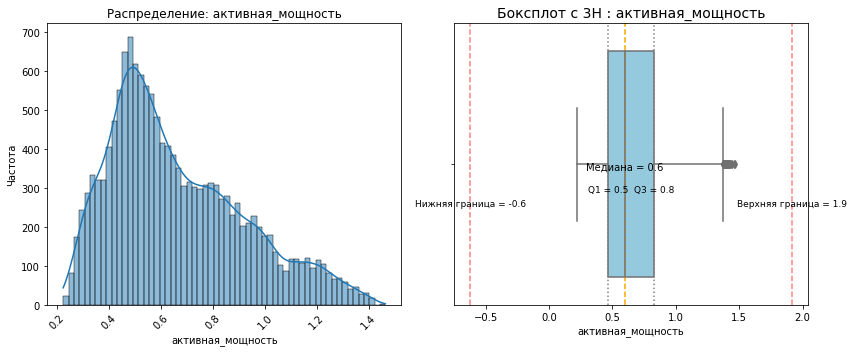

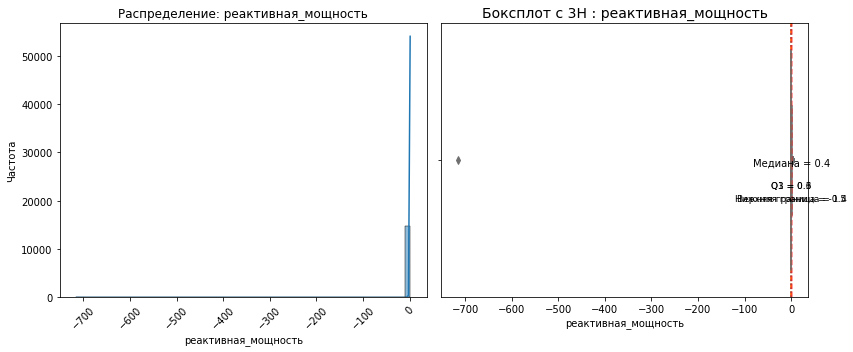

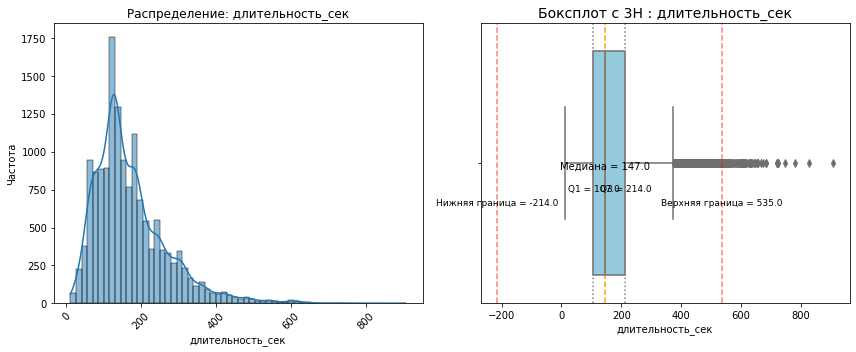

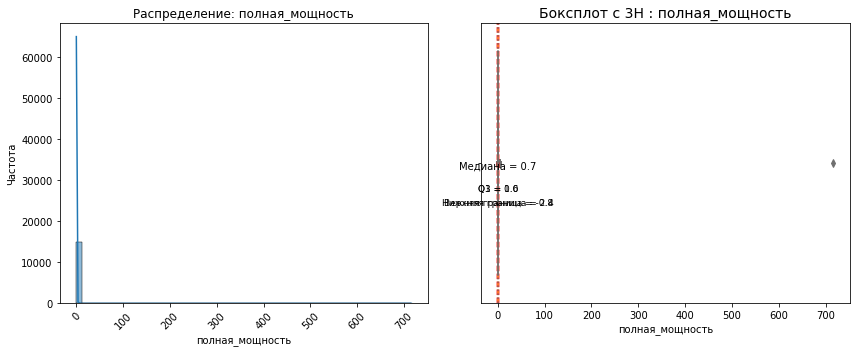

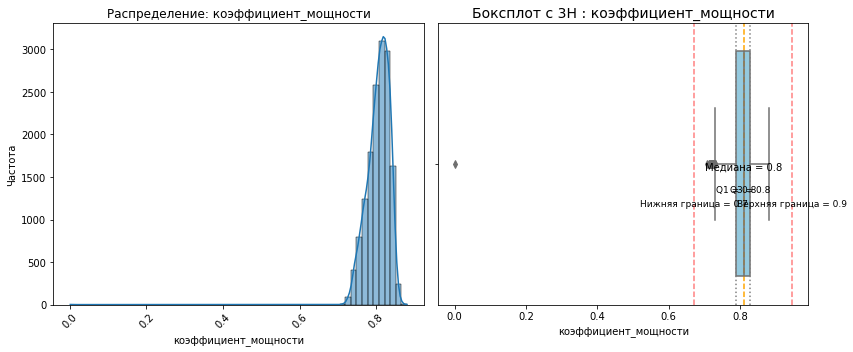

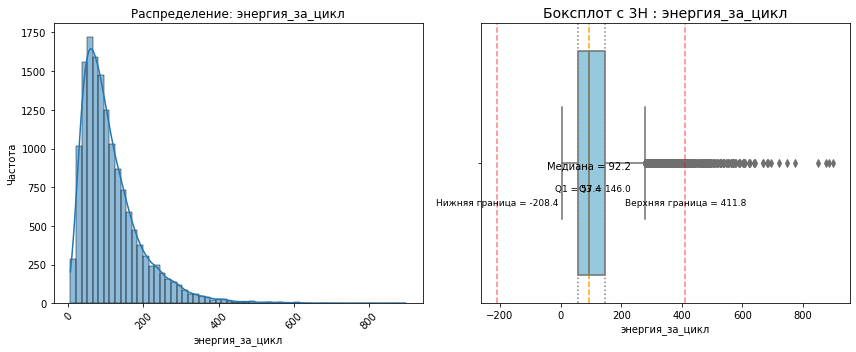

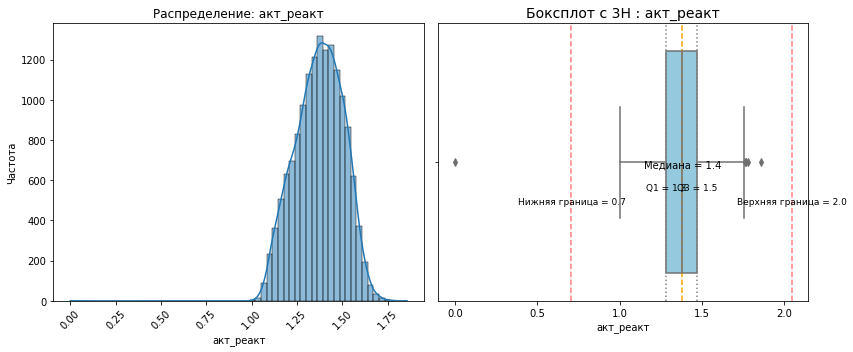

In [75]:
graf(data_arc)

Максимальные значения **активной мощности** вполне могут нормальным числом. Значение чуть выше верхней границы выбросом, формально это легкий выброс, но не экстремальный. Наиболее частые значения в районе 0,5

У **реактивной мощности** -700 однозначно выброс. Теоретически реактивная мощность может быть отрицательной, но такое большое значение выбивается из нашего диапазона

**длительность** более 600 сек кажется подозрительной

**полная мощность** более 700 - однозначно выброс. Эта строчка с выбросом удаляется, когда мы убираем выброс в реактивной мощности

**коэффициент мощности** в районе нуля тоже выглядит как выброс, как и отношение **акт/реакт**

По условию нам нужно либо удалить всю партию с аномальным значением, либо заменить аномальное значение, основываясь на нормальных наблюдениях. Т.к. таких партий не много- удалим их

In [76]:
bad_key1=data_arc.query('реактивная_мощность< -200')
data_arc1 = data_arc[~data_arc["key"].isin(bad_key1["key"])]

In [77]:
bad_key2 = data_arc1.query('длительность_сек> 650')
data_arc1 = data_arc1[~data_arc1["key"].isin(bad_key2["key"])]

In [78]:
(1-(data_arc1.shape[0]/data_arc.shape[0]))*100

0.719279376176396

Удалили меньше 1%

После удаления выбросов максимальное значение полной мощности 1.898 вполне реально в физическом диапазоне. Коэффициент мощности тоже вписывается в нормальный диапазон

In [79]:
data_arc1.head(5)

key начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
0    1           2019-05-03          2019-05-03           0.305130   
1    1           2019-05-03          2019-05-03           0.765658   
2    1           2019-05-03          2019-05-03           0.580313   
3    1           2019-05-03          2019-05-03           0.518496   
4    1           2019-05-03          2019-05-03           0.867133   

   реактивная_мощность  длительность_сек  полная_мощность  \
0             0.211253             228.0         0.371123   
1             0.477438             185.0         0.902319   
2             0.430460             172.0         0.722536   
3             0.379979             365.0         0.642824   
4             0.643691             148.0         1.079934   

   коэффициент_мощности  энергия_за_цикл  акт_реакт  
0              0.822181        69.569640   1.444382  
1              0.848545       141.646730   1.603680  
2              0.803161        99.813836   1.348123  
3              0.806591       189.251040   1.364539  
4              0.802950       128.335684   1.347126

In [80]:
data_arc1.query('энергия_за_цикл>680')

key начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
6014   1310           2019-06-21          2019-06-21           1.409275   
9125   1977           2019-07-22          2019-07-22           1.160538   
9182   1992           2019-07-23          2019-07-23           1.337070   
10602  2305           2019-08-03          2019-08-03           1.193678   

       реактивная_мощность  длительность_сек  полная_мощность  \
6014              1.128277             483.0         1.805288   
9125              0.767478             599.0         1.391356   
9182              1.000844             558.0         1.670163   
10602             0.764753             648.0         1.417644   

       коэффициент_мощности  энергия_за_цикл  акт_реакт  
6014               0.780637       680.679825   1.249051  
9125               0.834106       695.162262   1.512145  
9182               0.800563       746.085060   1.335942  
10602              0.842015       773.503344   1.560867

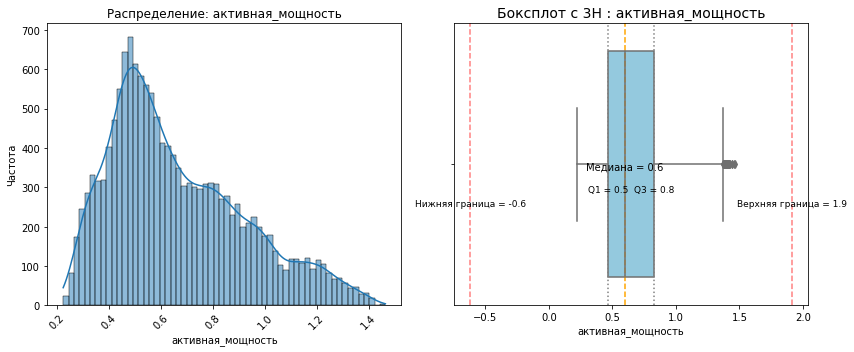

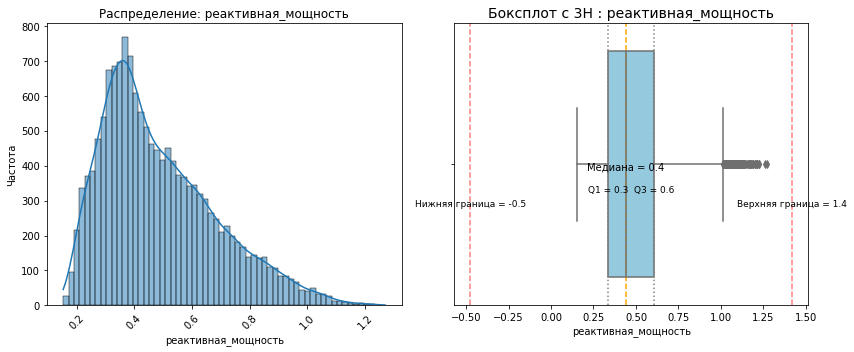

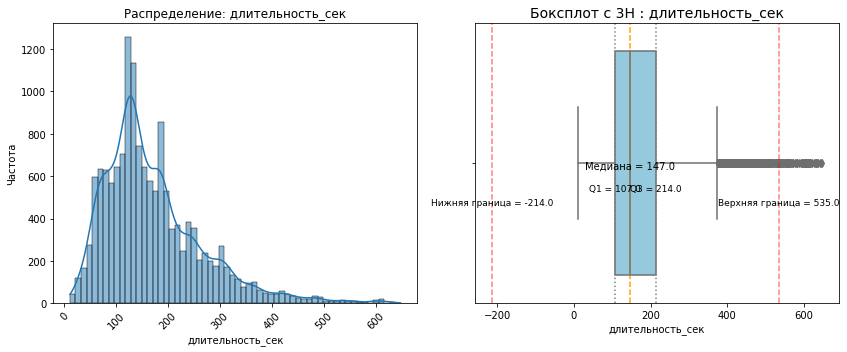

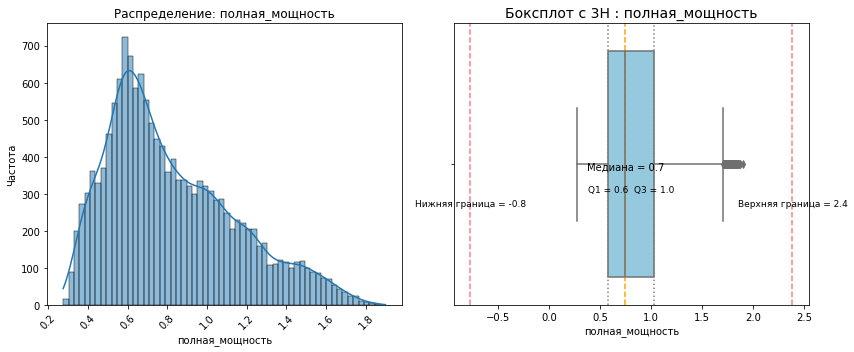

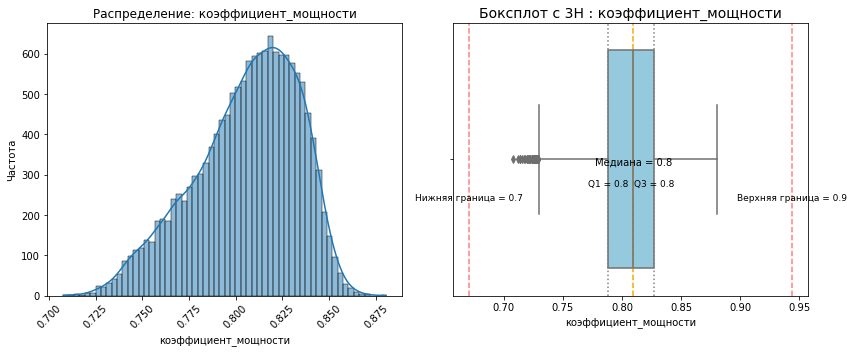

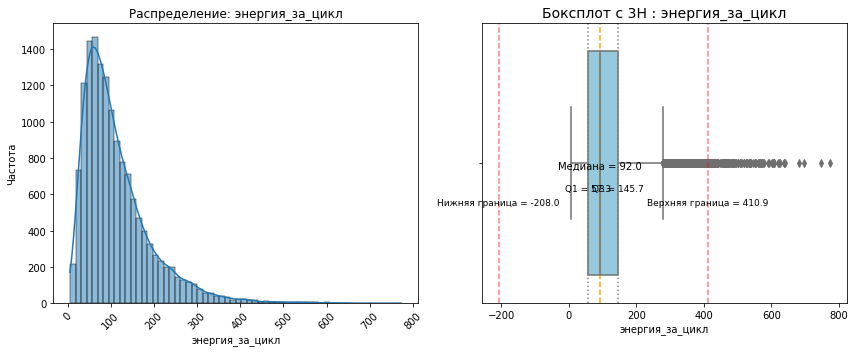

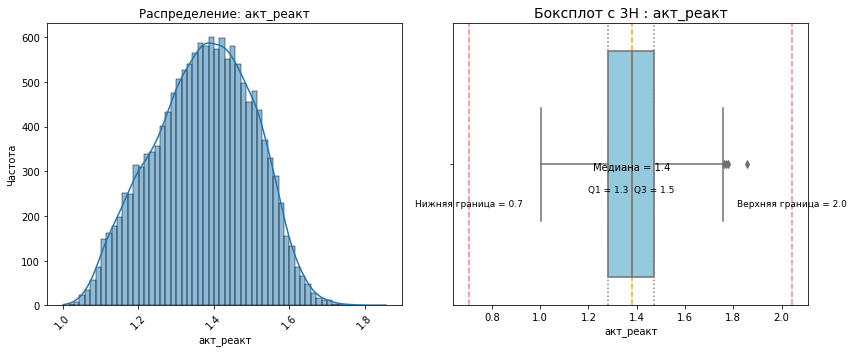

In [81]:
graf(data_arc1)

максимальные значения энергии за цикл вызывают вопросы. Мы видим что в этих слуях довольно большая длительность нагрева (за счет этого большая энергия), пока принимать за выбросы эти точки не будем

### **data_bulk**

In [82]:
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
       'bulk_14', 'bulk_15'],
      dtype='object')

In [83]:
data_bulk.describe()

key       bulk_1       bulk_2       bulk_3       bulk_4  \
count  3129.000000  3129.000000  3129.000000  3129.000000  3129.000000   
mean   1624.383509     3.160435     1.779163    47.240332    33.830617   
std     933.337642    11.869164    21.217878    74.239954    56.034505   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%     816.000000     0.000000     0.000000     0.000000     0.000000   
50%    1622.000000     0.000000     0.000000     0.000000     0.000000   
75%    2431.000000     0.000000     0.000000    80.000000    68.000000   
max    3241.000000   185.000000   325.000000   454.000000   281.000000   

            bulk_5       bulk_6       bulk_7       bulk_9      bulk_10  \
count  3129.000000  3129.000000  3129.000000  3129.000000  3129.000000   
mean      2.633749    21.892298     2.441675     0.463407     4.684564   
std      20.918138    55.492582    31.944063     6.154398    20.157323   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max     603.000000   503.000000   772.000000   147.000000   159.000000   

           bulk_11      bulk_12      bulk_13      bulk_14      bulk_15  
count  3129.000000  3129.000000  3129.000000  3129.000000  3129.000000  
mean      4.345478   203.948226     1.041866   152.706616   115.319271  
std      22.699580   151.419639    14.114252    81.091421    84.488698  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000   105.000000     0.000000   104.000000     0.000000  
50%       0.000000   206.000000     0.000000   148.000000   106.000000  
75%       0.000000   263.000000     0.000000   202.000000   204.000000  
max     313.000000  1849.000000   305.000000   636.000000   405.000000

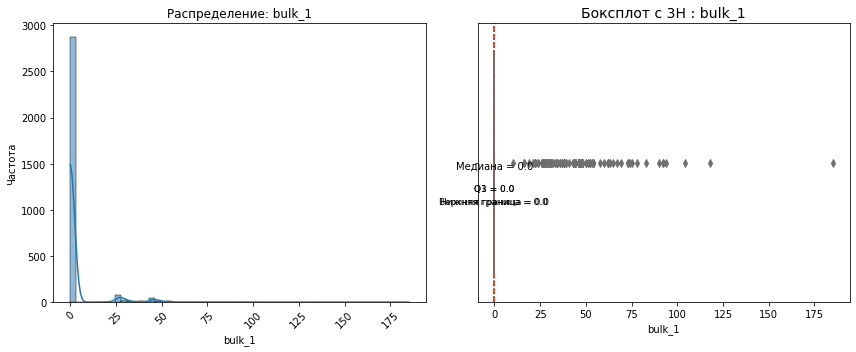

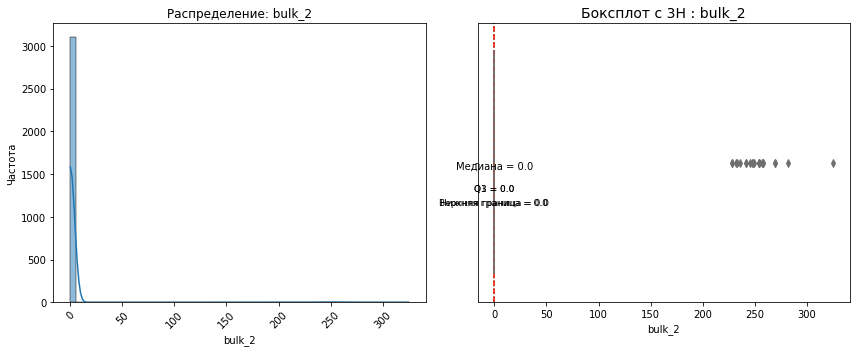

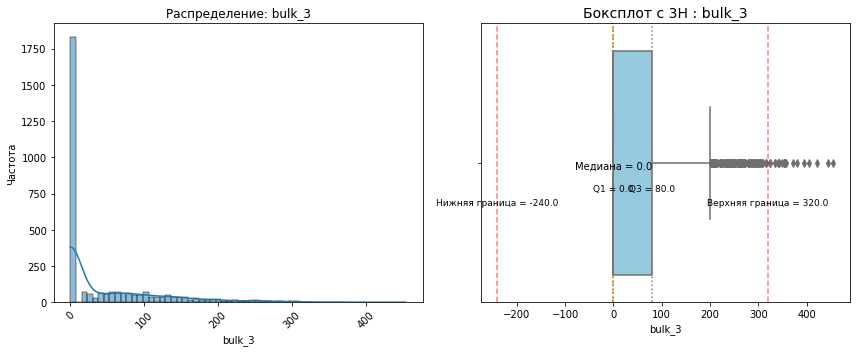

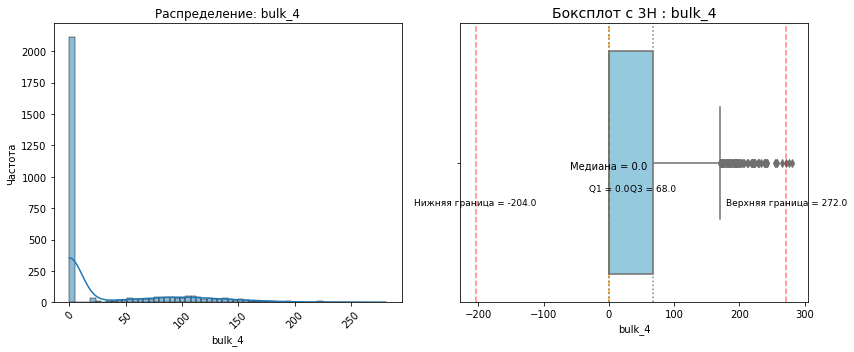

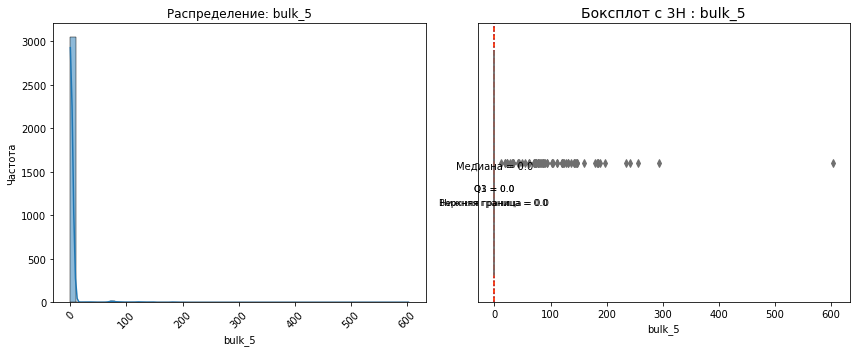

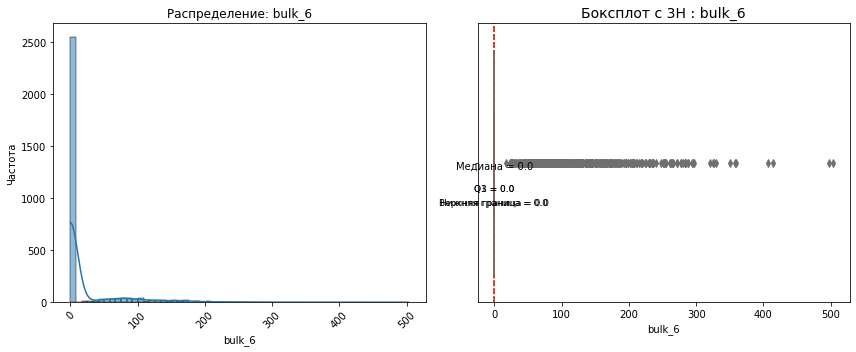

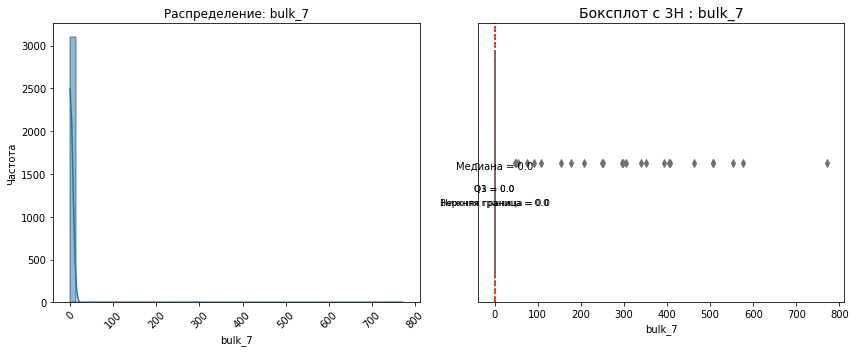

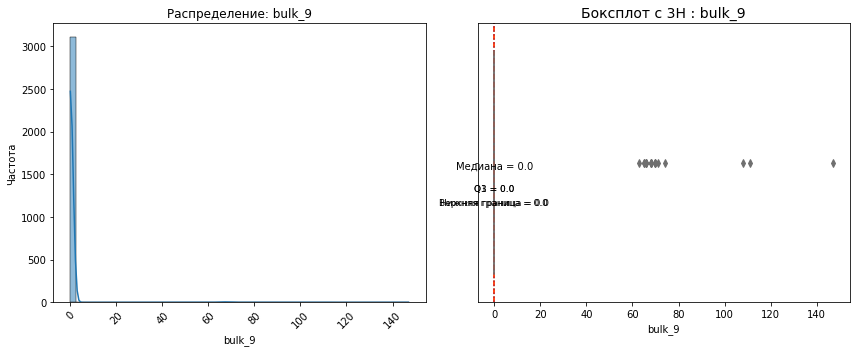

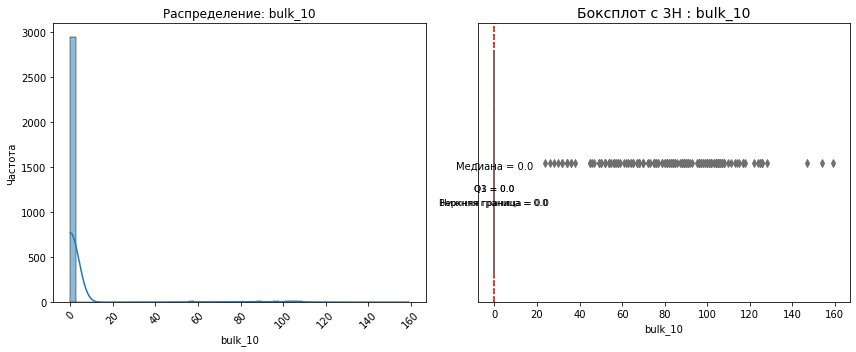

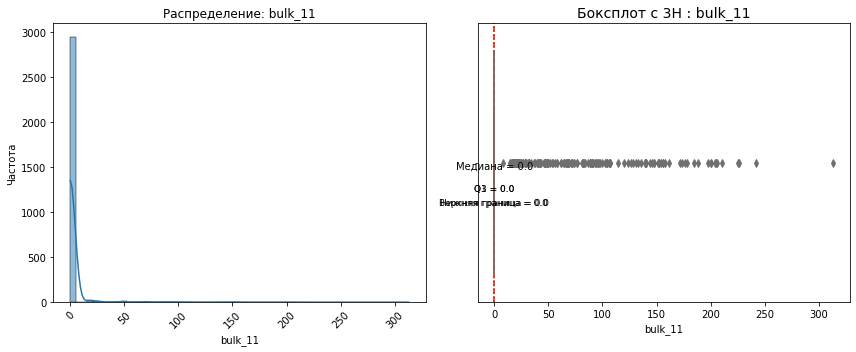

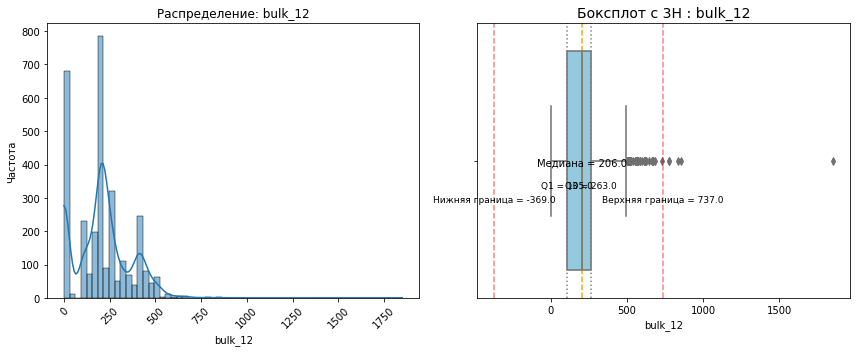

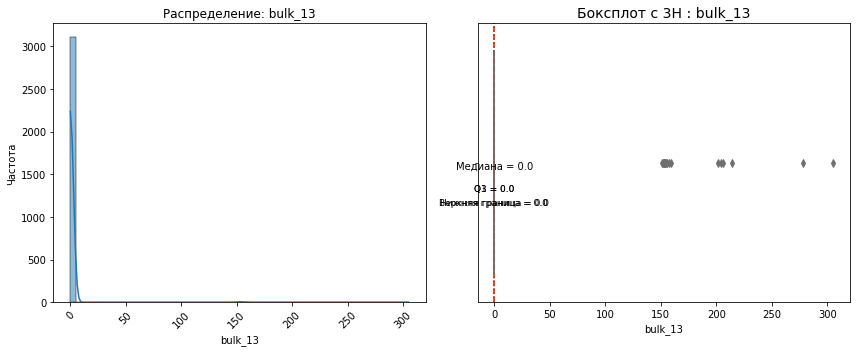

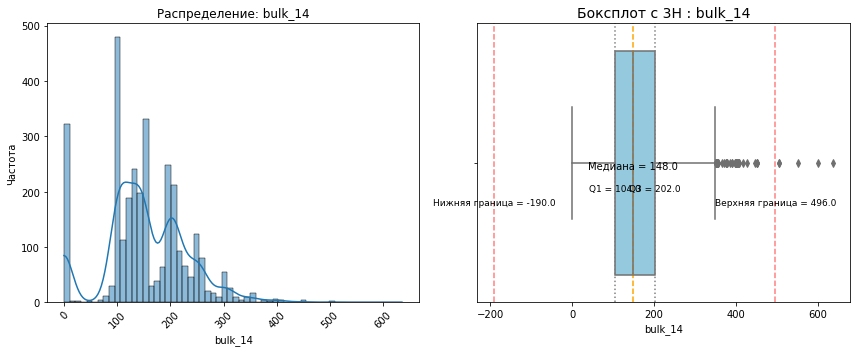

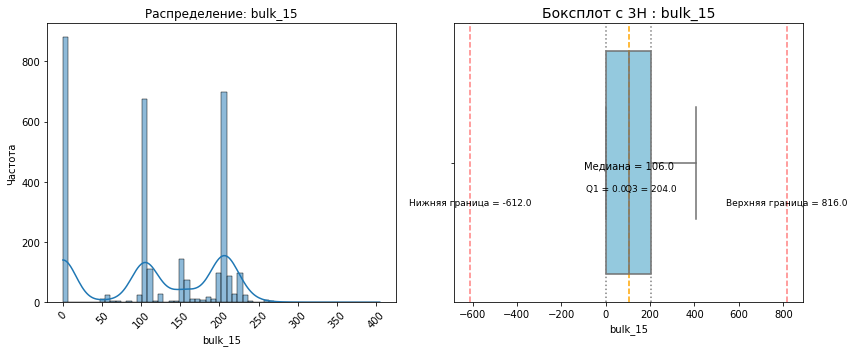

In [84]:
graf(data_bulk)

In [85]:
data_bulk.query('bulk_1>100')

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_9  \
303    322   185.0     0.0   101.0    58.0     0.0     0.0   406.0     0.0   
2423  2515   118.0     0.0   232.0     0.0     0.0   206.0     0.0     0.0   
2840  2946   104.0     0.0    62.0     0.0     0.0     0.0     0.0     0.0   

      bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
303       0.0      0.0   1849.0      0.0    636.0      0.0  
2423      0.0      0.0      0.0      0.0    452.0    108.0  
2840      0.0      0.0    464.0      0.0    238.0    126.0

У нас есть партии с очень большим объемом добавок. Возможно это ошибка записи(не те единицы),а возможно просто очень крупная партия. В технологическом процессе ковш может вмещать 100 тонн (по описанию), мы не знаем единицы измерения bulk, но знаем что это объем добавок. Предположим что это литры

Максимум для bulk1 - 185л. Рассчитаем вес. Из справочной информации плотность металлических сплавов/ферросплавов ~ 5–7 кг/л, порошковых или шлаковых материалов ~1–3 кг/л, легких сыпучих материалов (например, известь, оксид кальция) ~0.5–1 кг/л. 

Для bulk_1: (если плотность ≈ 5 кг/л) масса 185 * 5 = 925 кг (~1 т). Ковш вмещает 100 т стали, 1 т добавки ≈ 1 % объёма - вполне реально.
Даже bulk_12 = 1849 л * 5 кг/л = 9.2 т это  10 % от ковша - технологически допустимо. Редкая, но технологически допустимая крупная подача.

### **data_bulk_time**

In [86]:
bulk_cols = data_bulk_time.drop(columns='key').columns

In [87]:
def process_times_features(row, time_cols):
    """
    Вычисляет длительность процесса и максимальный интервал между подачами (в секундах).
    """
    times = row[time_cols].dropna().sort_values()
    if len(times) == 0:
        
        # Нет вообще данных - действительно пропуск
        return pd.Series({'process_duration': np.nan, 'max_interval': np.nan})
    elif len(times) == 1:
        
        # Одна подача — считаем длительность и интервал равными 0
        return pd.Series({'process_duration': 0.0, 'max_interval': 0.0})
    
    process_duration = (times.max() - times.min()).total_seconds()
    intervals = times.diff().dropna().dt.total_seconds()
    max_interval = intervals.max()
    
    return pd.Series({'process_duration': process_duration, 'max_interval': max_interval})

In [88]:
data_bulk_time[['process_duration_bulk', 'max_interval_bulk']] = (
    data_bulk_time.apply(process_times_features, axis=1, time_cols=bulk_cols))

In [89]:
data_bulk_time.head(2)

key bulk_1 bulk_2 bulk_3              bulk_4 bulk_5 bulk_6 bulk_7 bulk_9  \
0    1    NaT    NaT    NaT 2019-05-03 11:28:48    NaT    NaT    NaT    NaT   
1    2    NaT    NaT    NaT 2019-05-03 11:36:50    NaT    NaT    NaT    NaT   

  bulk_10 bulk_11             bulk_12 bulk_13             bulk_14  \
0     NaT     NaT 2019-05-03 11:24:31     NaT 2019-05-03 11:14:50   
1     NaT     NaT 2019-05-03 11:53:30     NaT 2019-05-03 11:48:37   

              bulk_15  process_duration_bulk  max_interval_bulk  
0 2019-05-03 11:10:43                 1085.0              581.0  
1 2019-05-03 11:44:39                 1000.0              469.0

In [90]:
data_bulk_time.describe().T

count         mean         std  min    25%     50%  \
key                    3129.0  1624.383509  933.337642  1.0  816.0  1622.0   
process_duration_bulk  3129.0   964.906679  798.088025  0.0  485.0   877.0   
max_interval_bulk      3129.0   570.205177  522.372634  0.0  329.0   473.0   

                          75%      max  
key                    2431.0   3241.0  
process_duration_bulk  1311.0  13683.0  
max_interval_bulk       733.0  12671.0

Средняя длительность процесса - 1066 сек (18 мин), реально для цикла легирования.
Медиана (50%) - 927сек (~15 минут), тоже соответствует типичному процессу.

25-й и 75-й перцентили - 594–1366 сек (~10–23 минуты), это нормальный разброс.

Минимум 0 - две добавки поданы одновременно, процесс есть, просто интервалы между событиями равны 0.
NaN - если анализ показывает, что нужные элементы уже на требуемом уровне, добавки не вводят.

Максимум = 13683 сек (~3,8 часа) - сильно выше реальной длительности цикла, вероятно выброс/ошибка.

*У нас есть выбросы: длительность более 3 часов*. Оставим в качестве верхней границы процесса 5000 сек (1,5ч).  Длительность 0 секунд - это те случаи когда несколько веществ добавили одновременно и продули в одном цикле

Максимальный интервал 3907 с (~1 час 5 минут) — это верхняя граница, возможен в реальных условиях (например, задержка между подачами из-за измерений, нагрева или ожидания).

In [91]:
data_bulk_time[data_bulk_time['process_duration_bulk']==0].head(2)

key bulk_1 bulk_2 bulk_3 bulk_4 bulk_5              bulk_6 bulk_7 bulk_9  \
15   16    NaT    NaT    NaT    NaT    NaT                 NaT    NaT    NaT   
18   19    NaT    NaT    NaT    NaT    NaT 2019-05-04 01:14:08    NaT    NaT   

   bulk_10 bulk_11             bulk_12 bulk_13             bulk_14  \
15     NaT     NaT 2019-05-03 22:33:22     NaT 2019-05-03 22:33:22   
18     NaT     NaT                 NaT     NaT                 NaT   

               bulk_15  process_duration_bulk  max_interval_bulk  
15 2019-05-03 22:33:22                    0.0                0.0  
18                 NaT                    0.0                0.0

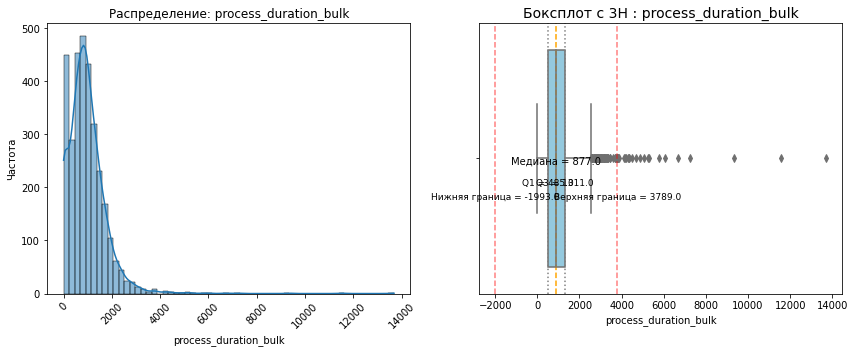

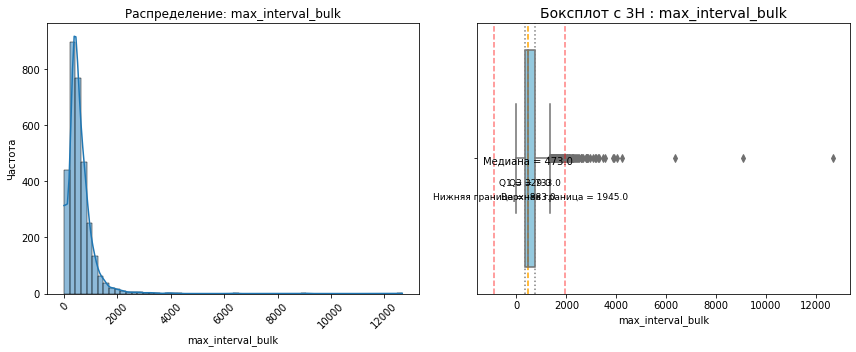

In [92]:
graf(data_bulk_time)

<AxesSubplot:xlabel='process_duration_bulk', ylabel='Count'>

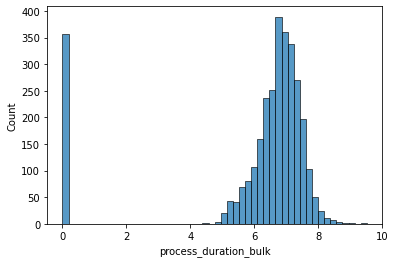

In [93]:
sns.histplot(np.log1p(data_bulk_time['process_duration_bulk']), bins=50)

На логарифмической гистограмме видно, что это не отдельный шип, а кусок плавного хвоста. Принимать за выброс не будем

Оставим только столбцы с интервалами

In [94]:
data_bulk_time1 = data_bulk_time[['key','process_duration_bulk','max_interval_bulk']]

### **data_gas**

In [95]:
data_gas.describe().T

count         mean         std       min         25%          50%  \
key    3239.0  1621.861377  935.386334  1.000000  812.500000  1622.000000   
газ_1  3239.0    11.002062    6.220327  0.008399    7.043089     9.836267   

               75%         max  
key    2431.500000  3241.00000  
газ_1    13.769915    77.99504

In [96]:
data_gas.head(2)


key      газ_1
0    1  29.749986
1    2  12.555561

Стоит посмотреть на строчки с минимальным и максимальными значениями. Это может быть очень маленький(или наоборот очень большой) размер партии или выбросы

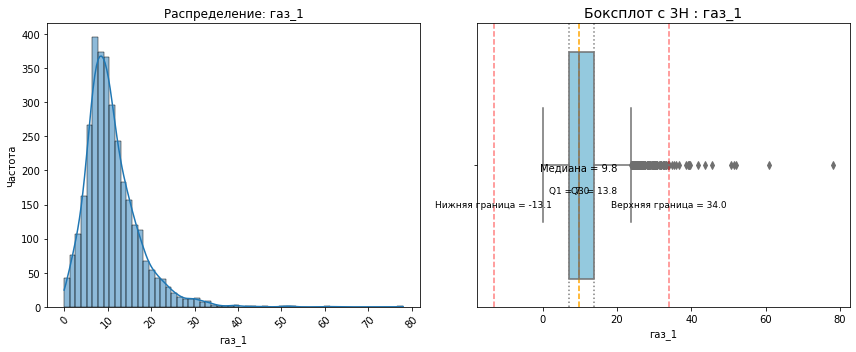

In [97]:
graf(data_gas)

In [98]:
data_gas.query('газ_1<0.2 or газ_1>50').sort_values('газ_1')

key      газ_1
863    866   0.008399
1044  1047   0.016696
116    117  50.581035
2567  2570  51.380229
2107  2110  52.142373
277    280  60.935689
319    322  77.995040

нас интересует объем партий key 866, 1047, 280, 322

Посмтрим те партии, где объем газа минимальный

In [99]:
data_bulk.query('key in [866, 1047]')

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_9  \
831    866     0.0     0.0   124.0     0.0     0.0     0.0     0.0     0.0   
1002  1047     0.0     0.0     0.0     0.0     0.0    49.0     0.0     0.0   

      bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
831       0.0      0.0      0.0      0.0      0.0      0.0  
1002      0.0     32.0    206.0      0.0    128.0    103.0

In [100]:
data_bulk_time.query('key in [866, 1047]')

key bulk_1 bulk_2              bulk_3 bulk_4 bulk_5  \
831    866    NaT    NaT 2019-06-06 07:38:57    NaT    NaT   
1002  1047    NaT    NaT                 NaT    NaT    NaT   

                  bulk_6 bulk_7 bulk_9 bulk_10             bulk_11  \
831                  NaT    NaT    NaT     NaT                 NaT   
1002 2019-06-12 17:48:44    NaT    NaT     NaT 2019-06-12 18:03:07   

                 bulk_12 bulk_13             bulk_14             bulk_15  \
831                  NaT     NaT                 NaT                 NaT   
1002 2019-06-12 17:59:48     NaT 2019-06-12 17:54:05 2019-06-12 17:48:44   

      process_duration_bulk  max_interval_bulk  
831                     0.0                0.0  
1002                  863.0              343.0

Минимум ≈ 0,008 — скорее всего запись ошибки или почти нулевая подача (малые партии или тест).

В случае 866 была всего одна средняя добавка. Возможно такого малого объема газа хватило чтобы перемешать партию.
в случае 1047 добавок было несколько в разное время, скорее всего продувов тоже было несколько. Судя по объему добавок партия не самая маленькая и такой маленький объем газа похож на выброс, он он не выходит за границы супервыбросов и больше нуля. Поэтому оставим

и максимальный

In [101]:
data_bulk.query('key in [280, 322]')

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_9  \
262  280     0.0     0.0   126.0     0.0     0.0     0.0     0.0    63.0   
303  322   185.0     0.0   101.0    58.0     0.0     0.0   406.0     0.0   

     bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
262      0.0      0.0    108.0      0.0    263.0      0.0  
303      0.0      0.0   1849.0      0.0    636.0      0.0

In [102]:
data_bulk_time.query('key in [280, 322]')

key              bulk_1 bulk_2              bulk_3              bulk_4  \
262  280                 NaT    NaT 2019-05-14 12:03:22                 NaT   
303  322 2019-05-15 23:03:53    NaT 2019-05-15 22:59:04 2019-05-15 22:51:21   

    bulk_5 bulk_6              bulk_7              bulk_9 bulk_10 bulk_11  \
262    NaT    NaT                 NaT 2019-05-14 11:57:58     NaT     NaT   
303    NaT    NaT 2019-05-15 22:42:51                 NaT     NaT     NaT   

                bulk_12 bulk_13             bulk_14 bulk_15  \
262 2019-05-14 11:51:26     NaT 2019-05-14 11:46:48     NaT   
303 2019-05-15 22:16:39     NaT 2019-05-15 22:11:53     NaT   

     process_duration_bulk  max_interval_bulk  
262                  994.0              392.0  
303                 3120.0             1572.0

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн.

key 280 - есть добавки большого размера, партия крупная, время длительности процесса 16 мин, включает в себя несколько циклов перемешивания. В таком контексте объем газа около 61л - реалистичная цифра

key 322 действительно большая партия с несколькими циклами добавок и перемешивания (длительность 52 мин). Интервал между подачами, очень большой, но логично, если между первым и вторым этапом легирования был длительный промежуток (нагрев, измерения, пауза). 1572 с — верхняя граница реальной задержки. Такой объем газа (78 л) может быть реальным значением, несмторя на то,что эта точка сильно выбивается на боксплоте газа (и боксплоте времени и количества добавок)

### **df_target**

Вычислим истинную длительность процесса: из времени последнего замера вычтем время первого замера температуры

In [103]:
df_target['полная_длительность'] = ((df_target['время_последнего_замера'] - df_target['время_первого_замера'])
                                     .dt.total_seconds())


In [104]:
df_target.head(3)

key время_последнего_замера  температура время_первого_замера  \
0    1     2019-05-03 11:30:38       1613.0  2019-05-03 11:02:04   
1    2     2019-05-03 11:55:09       1602.0  2019-05-03 11:34:04   
2    3     2019-05-03 12:35:57       1599.0  2019-05-03 12:06:44   

   температура_первого_замера  количество_замеров  полная_длительность  
0                      1571.0                   6               1714.0  
1                      1581.0                   5               1265.0  
2                      1596.0                   6               1753.0

In [105]:
df_target.describe().T

count         mean          std     min     25%  \
key                         2477.0  1249.968510   720.073717     1.0   628.0   
температура                 2477.0  1595.334275    16.019339  1541.0  1587.0   
температура_первого_замера  2477.0  1588.405733    29.232904  1191.0  1572.0   
количество_замеров          2477.0     5.622124     1.614793     1.0     5.0   
полная_длительность         2477.0  2279.054905  1374.678745     0.0  1541.0   

                               50%     75%      max  
key                         1251.0  1872.0   2499.0  
температура                 1593.0  1599.0   1700.0  
температура_первого_замера  1588.0  1605.0   1679.0  
количество_замеров             5.0     7.0     17.0  
полная_длительность         2007.0  2738.0  23674.0

минимальное время 0 выброс(либо ошибка записи, либо процесс не пошел). полная дительность более 23 тыс сек скорее всего выброс

минимальная входная температура 1191 очень маленькая, скорее всего выброс.  Даже если сталь успела немного остыть после выпуска из конвертера, ниже 1500 °C — уже нерабочее состояние: металл начнёт затвердевать по краям ковша, и обработка невозможна.

Температура на выходе 1700 - очень большая, но не "ошибка", а редкое, технологически возможное, но крайне высокое значение. Максимум безопасного диапазона для большинства сталей — около 1650 – 1670 °C. 1700 °C — это уже верх технологических возможностей, обычно кратковременно и для специальных марок (например, при продувке газом, легировании тугоплавкими элементами, или при перегреве перед разливкой).

In [106]:
df_target[df_target['полная_длительность']==0]

key время_последнего_замера  температура время_первого_замера  \
192  195     2019-05-11 00:01:36       1583.0  2019-05-11 00:01:36   
276  279     2019-05-14 10:13:01       1603.0  2019-05-14 10:13:01   

     температура_первого_замера  количество_замеров  полная_длительность  
192                      1583.0                   1                  0.0  
276                      1603.0                   1                  0.0

в нашем случае длительность 0-процесс не пошел

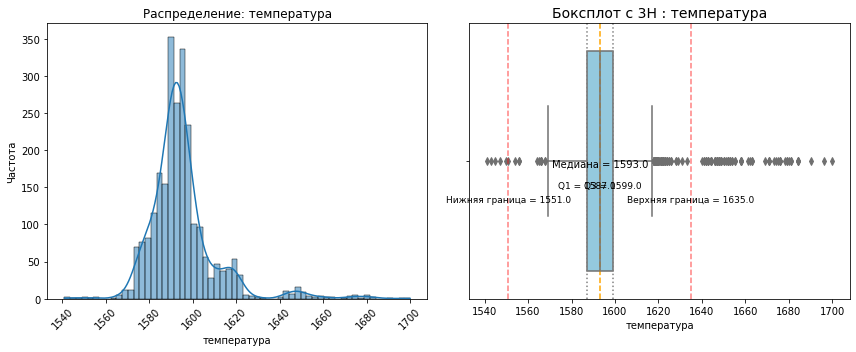

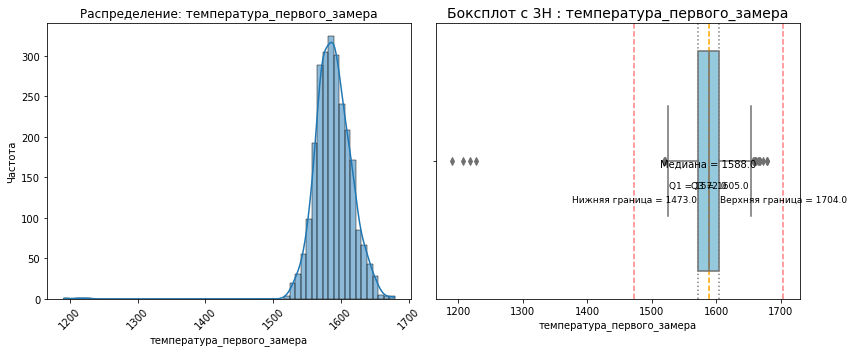

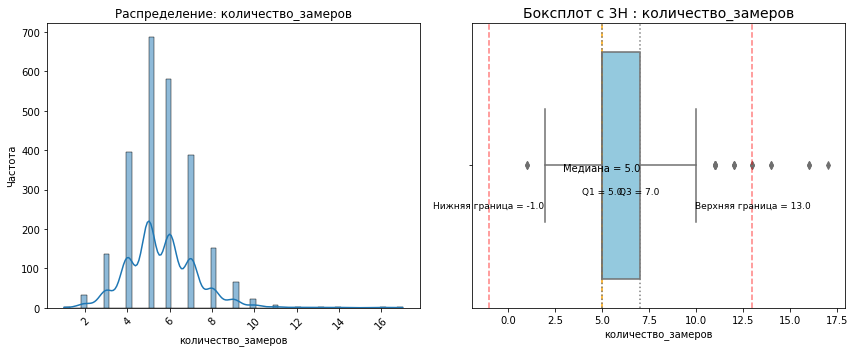

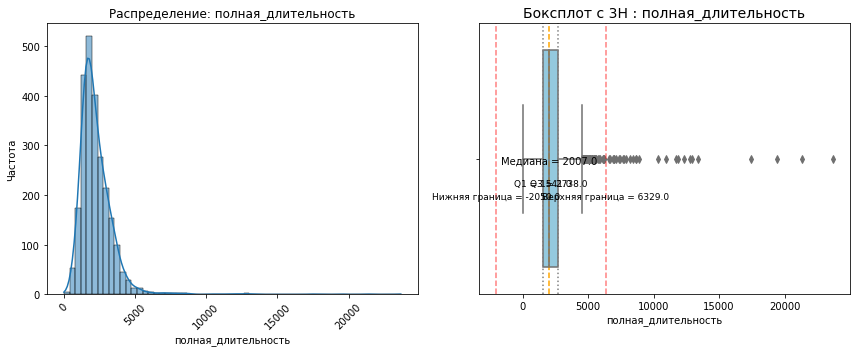

In [107]:
graf(df_target)

In [108]:
key_long_time = df_target[df_target['полная_длительность']>15000]['key']
key_long_time 

632      641
1674    1689
1943    1958
2091    2108
Name: key, dtype: int64

In [109]:
data_bulk_time[data_bulk_time['key'].isin(key_long_time)][['key','process_duration_bulk','max_interval_bulk']]

key  process_duration_bulk  max_interval_bulk
611    641                 1793.0              804.0
1629  1689                 1747.0              707.0
1895  1958                13683.0            12671.0
2036  2108                 4480.0             3082.0

In [110]:
data_bulk[data_bulk['key'].isin(key_long_time)]

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_9  \
611    641     0.0     0.0     0.0    60.0     0.0     0.0     0.0     0.0   
1629  1689     0.0     0.0     0.0     0.0     0.0   247.0     0.0     0.0   
1895  1958     0.0     0.0    31.0     0.0     0.0   175.0     0.0     0.0   
2036  2108    63.0   242.0     0.0    98.0    94.0     0.0   507.0     0.0   

      bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
611       0.0      0.0    208.0    153.0      0.0    156.0  
1629      0.0      0.0    733.0    305.0    248.0    224.0  
1895      0.0      0.0    310.0      0.0    180.0    202.0  
2036      0.0      0.0      0.0      0.0      0.0      0.0

В сомнительных случаях, когда длительность кажется большой мы видим большие интервалы между подачами материала, большой объем добавок. Пока не будем считать эти строки выбросами

Удалим явные выбросы: температуру меньше 1500 и длительность более 15000 и нулевую

In [111]:
df_target.shape

(2477, 7)

In [112]:
df_target = df_target.query('температура_первого_замера>1500')

In [113]:
df_target = df_target.query('(полная_длительность>0) and (полная_длительность<15000)')
df_target.shape

(2467, 7)

оставим только нужные столбцы:

In [114]:
df_target1 = df_target[['key','полная_длительность','температура_первого_замера','температура', 'количество_замеров']]

In [115]:
df_target1.head(2)

key  полная_длительность  температура_первого_замера  температура  \
0    1               1714.0                      1571.0       1613.0   
1    2               1265.0                      1581.0       1602.0   

   количество_замеров  
0                   6  
1                   5

### **data_wire**

In [116]:
data_wire.describe()

key       wire_1       wire_2       wire_3       wire_4  \
count  3081.000000  3081.000000  3081.000000  3081.000000  3081.000000   
mean   1623.426485   100.044411    17.712733     3.874524     0.261019   
std     932.996726    42.841120    33.517734    30.310417     4.293865   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%     823.000000    70.281120     0.000000     0.000000     0.000000   
50%    1619.000000   100.114563     0.000000     0.000000     0.000000   
75%    2434.000000   125.798405    23.162880     0.000000     0.000000   
max    3241.000000   330.314424   282.780152   385.008668   113.231044   

            wire_6       wire_7       wire_8       wire_9  
count  3081.000000  3081.000000  3081.000000  3081.000000  
mean      1.137695     0.035842     0.330697     0.321492  
std       8.958111     0.774190     4.392677     3.806904  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000  
max     180.454575    32.847674   102.762401    90.053604

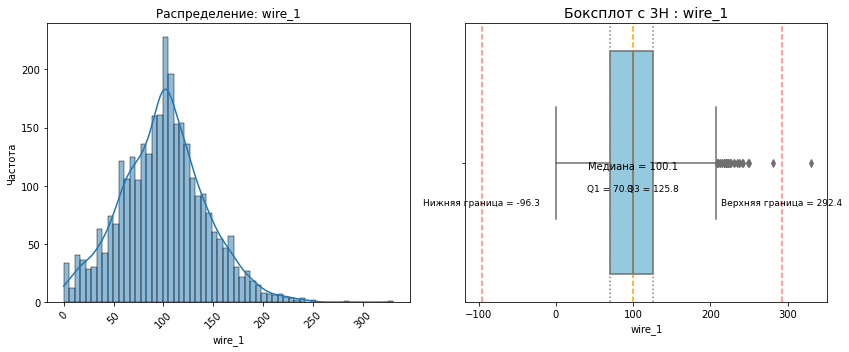

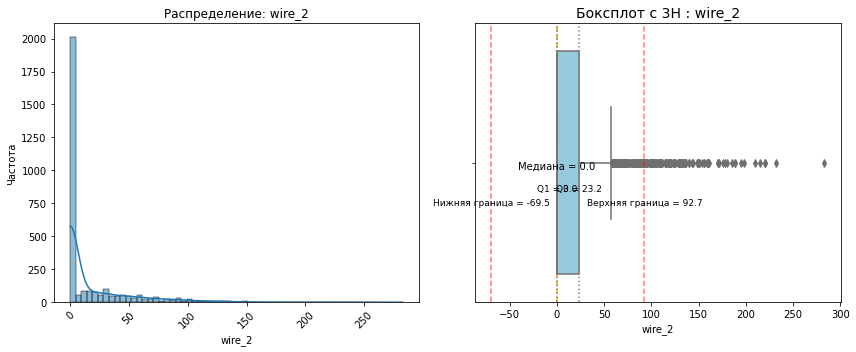

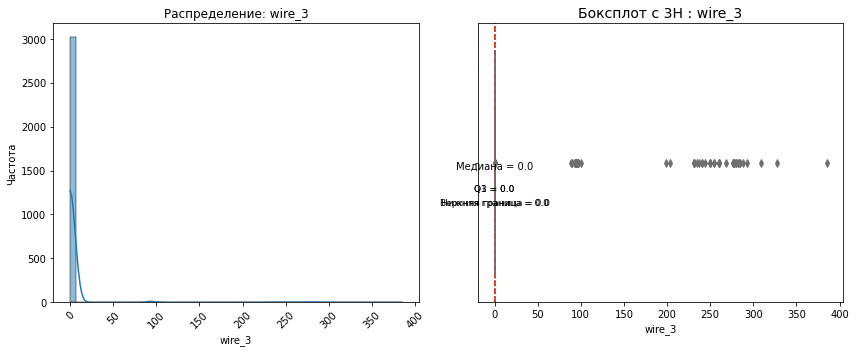

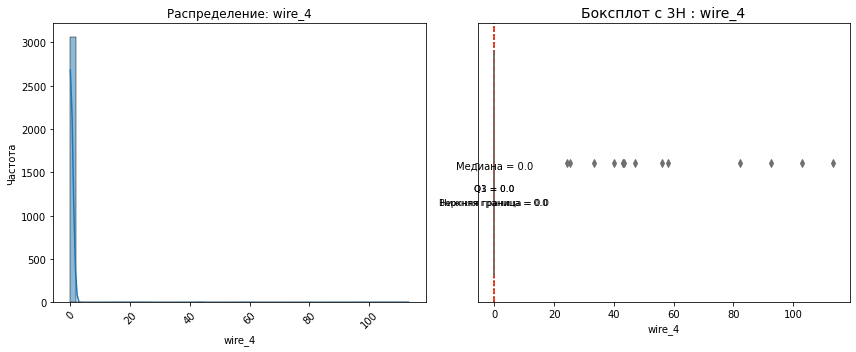

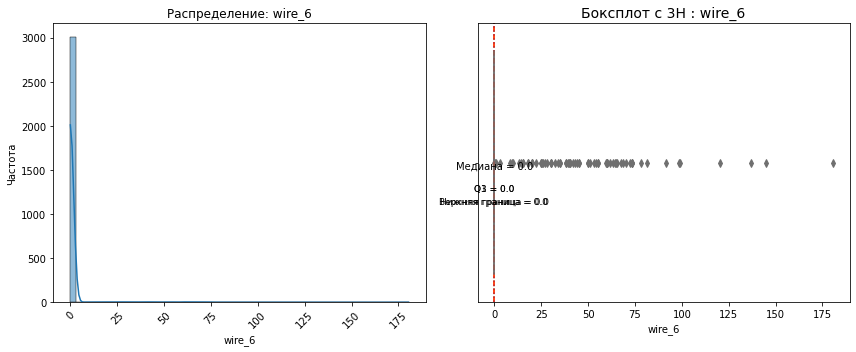

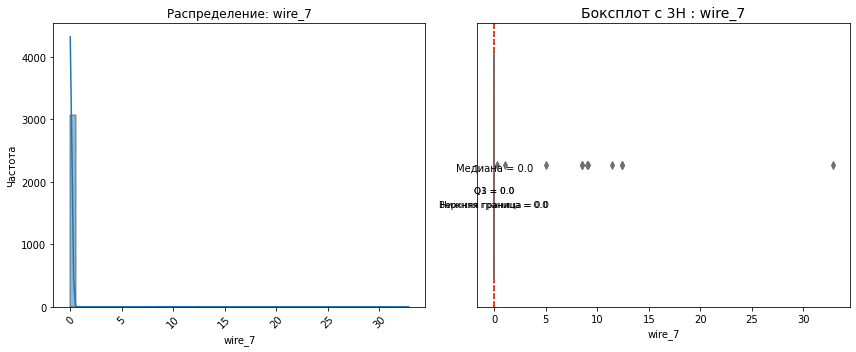

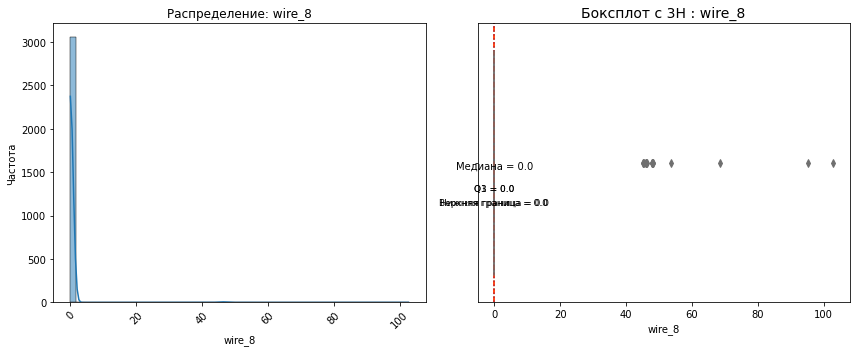

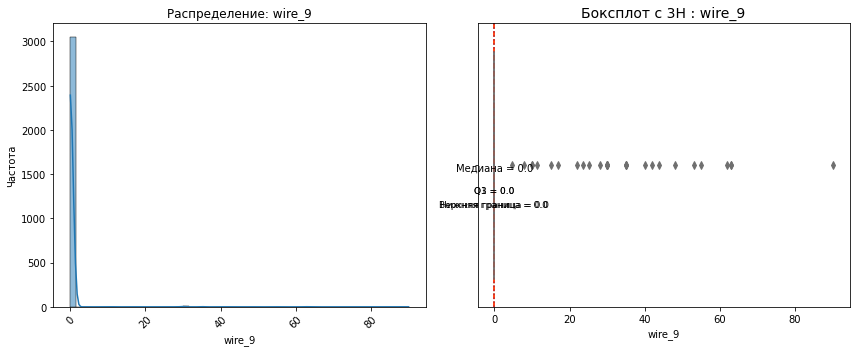

In [117]:
graf(data_wire)

несмотря на точки на боксплотах все значения допустимы. даже 330 л если перевесети в кг (предположим что плотность 5кг/л) 1650 кг - 1.65 % от ковша, вполне реалистично, нормальный крупный объем партии

### **data_wire_time**

In [118]:
wire_cols = data_wire_time.drop(columns='key').columns

In [119]:
data_wire_time[['process_duration_wire', 'max_interval_wire']] = (
    data_wire_time.apply(process_times_features, axis=1, time_cols=wire_cols))

In [120]:
data_wire_time.head(1)

key              wire_1 wire_2 wire_3 wire_4 wire_6 wire_7 wire_8 wire_9  \
0    1 2019-05-03 11:06:19    NaT    NaT    NaT    NaT    NaT    NaT    NaT   

   process_duration_wire  max_interval_wire  
0                    0.0                0.0

In [121]:
data_wire_time.describe().T

count         mean         std  min    25%     50%  \
key                    3081.0  1623.426485  932.996726  1.0  823.0  1619.0   
process_duration_wire  3081.0   214.519312  396.131967  0.0    0.0     0.0   
max_interval_wire      3081.0   199.222655  333.912285  0.0    0.0     0.0   

                          75%     max  
key                    2434.0  3241.0  
process_duration_wire   401.0  5937.0  
max_interval_wire       395.0  4170.0

75 % значений менее 11мин — большинство плавок укладывается в короткий цикл.
max 5937 сек - почти 1 час 40 мин,что очень длинно для одной партии проволочных подач.
std 461 говорит, что длительность варьируется сильно (есть и короткие, и редкие длинные).

Процесс подачи более 1ч скорее выброс или технологические задержки

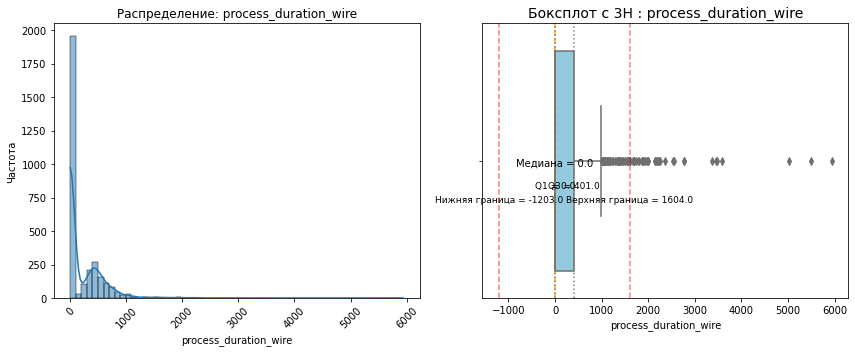

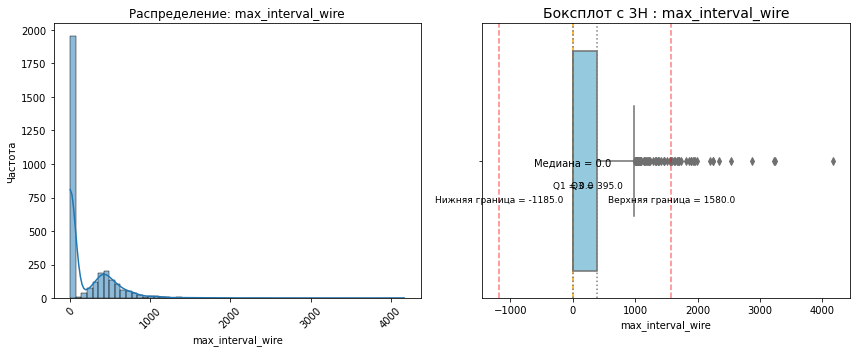

In [122]:
graf(data_wire_time)

long_time_wire =  data_wire_time.query('process_duration_wire > 5000').index
data_wire_time = data_wire_time.drop(index=long_time_wire)

Тоже выходит за границы супервыбросов 3H

Оставим только столбцы с интервалами

In [123]:
data_wire_time1 = data_wire_time[['key','process_duration_wire', 'max_interval_wire']]

In [124]:
data_wire_time1.shape

(3081, 3)

## **Объединение таблиц**

Условия для объединения: каждой партии должно соответствовать одно наблюдение, во все партии точно добавлялись сыпучие и проволочные материалы, везде была выполнена продувка газом и сплав всегда нагревался.

Значит, все таблицы содержат одинаковые партии (key пересекается у всех), в объединённой таблице не должно быть пропусков. Логично использовать внутреннее объединение (inner join).

Наши таблицы с почищенными выбросами:
    
*data_arc1, data_bulk, data_bulk_time1, data_gas, df_target1, data_wire, data_wire_time1*

Подготовим таблицу data_arc1. Агрегируем по ключу. Признаки которые будем брать:

- 'длительность_сек'- суммарную за все циклы (т.к. у нас есть еще отдельные тайминги при внесении добавок и общая от первого до последнего измерения температуры). Покажет, как долго реально грели сталь.
 - 'ActivePower' - среднее,
 - 'ReactivePower'- среднее,
 - 'полная_мощность' - среднее,
 - 'коэффициент_мощности' - среднее,
 - 'энергия_за_цикл'- возьмем суммарную, т.к. мы хотим описать весь процесс. Вся подведённая энергия отражает общий расход электричества на обработку партии
 - 'акт_реакт'- среднее

In [125]:
data_arc1.head(1)

key начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
0    1           2019-05-03          2019-05-03            0.30513   

   реактивная_мощность  длительность_сек  полная_мощность  \
0             0.211253             228.0         0.371123   

   коэффициент_мощности  энергия_за_цикл  акт_реакт  
0              0.822181         69.56964   1.444382

In [126]:
data_arc_agg = (
    data_arc1.groupby('key')
    .agg({'длительность_сек': ['sum'],
          'активная_мощность': ['mean'],
          'реактивная_мощность': ['mean'],
          'полная_мощность': ['mean'],
          'коэффициент_мощности': ['mean'],
          'энергия_за_цикл': ['sum'],
          'акт_реакт': ['mean']}))

Добавим количество циклов нагрева

In [127]:
data_arc_agg['число_циклов'] = data_arc1.groupby('key').size()

In [128]:
data_arc_agg.head(1)

длительность_сек активная_мощность реактивная_мощность полная_мощность  \
                 sum              mean                mean            mean   
key                                                                          
1             1098.0          0.607346            0.428564        0.743747   

    коэффициент_мощности энергия_за_цикл акт_реакт число_циклов  
                    mean             sum      mean               
key                                                              
1               0.816686       628.61693   1.42157            5

Переименуем мультииндекс в более осмысленные имена

In [129]:
data_arc_agg.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in data_arc_agg.columns]

In [130]:
data_arc_agg.rename(columns={
    'длительность_сек_sum': 'длит_нагрева',
    'активная_мощность_mean': 'акт_мощ_avg',
    'реактивная_мощность_mean': 'реакт_мощ_avg',
    'полная_мощность_mean': 'полн_мощ_avg',
    'коэффициент_мощности_mean': 'коэф_мощ_avg',
    'энергия_за_цикл_sum': 'энер_плавки',
    'акт_реакт_mean': 'акт_реакт_avg',
    'число_циклов_': 'число_циклов'
}, inplace=True)

In [131]:
data_arc_agg.head(2)

длит_нагрева  акт_мощ_avg  реакт_мощ_avg  полн_мощ_avg  коэф_мощ_avg  \
key                                                                         
1          1098.0     0.607346       0.428564      0.743747      0.816686   
2           811.0     0.534852       0.363339      0.647087      0.825276   

     энер_плавки  акт_реакт_avg  число_циклов  
key                                            
1      628.61693       1.421570             5  
2      395.28180       1.479201             4

In [132]:
df_target1 = df_target1.set_index('key')
data_bulk = data_bulk.set_index('key')
data_bulk_time1 = data_bulk_time1.set_index('key')
data_gas = data_gas.set_index('key')
data_wire = data_wire.set_index('key')
data_wire_time1 = data_wire_time1.set_index('key')

In [133]:
full_df = (df_target1
    .join(data_arc_agg, how='inner')
    .join(data_bulk, how='inner')
    .join(data_bulk_time1, how='inner')
    .join(data_gas, how='inner')
    .join(data_wire, how='inner')
    .join(data_wire_time1, how='inner'))


print(full_df.shape)


(2308, 39)


In [134]:
full_df.head(3)

полная_длительность  температура_первого_замера  температура  \
key                                                                 
1                 1714.0                      1571.0       1613.0   
2                 1265.0                      1581.0       1602.0   
3                 1753.0                      1596.0       1599.0   

     количество_замеров  длит_нагрева  акт_мощ_avg  реакт_мощ_avg  \
key                                                                 
1                     6        1098.0     0.607346       0.428564   
2                     5         811.0     0.534852       0.363339   
3                     6         655.0     0.812728       0.587491   

     полн_мощ_avg  коэф_мощ_avg  энер_плавки  ...     wire_1  wire_2  wire_3  \
key                                           ...                              
1        0.743747      0.816686   628.616930  ...  60.059998     0.0     0.0   
2        0.647087      0.825276   395.281800  ...  96.052315     0.0     0.0   
3        1.003845      0.809724   581.774624  ...  91.160157     0.0     0.0   

     wire_4  wire_6  wire_7  wire_8  wire_9  process_duration_wire  \
key                                                                  
1       0.0     0.0     0.0     0.0     0.0                    0.0   
2       0.0     0.0     0.0     0.0     0.0                    0.0   
3       0.0     0.0     0.0     0.0     0.0                    0.0   

     max_interval_wire  
key                     
1                  0.0  
2                  0.0  
3                  0.0  

[3 rows x 39 columns]

In [135]:
full_df.describe().T

count         mean          std          min  \
полная_длительность         2308.0  2286.533795  1152.636439   339.000000   
температура_первого_замера  2308.0  1587.502600    23.494652  1519.000000   
температура                 2308.0  1593.380416    11.113553  1543.000000   
количество_замеров          2308.0     5.679376     1.570858     2.000000   
длит_нагрева                2308.0   801.322357   326.342870    57.000000   
акт_мощ_avg                 2308.0     0.664051     0.128284     0.267676   
реакт_мощ_avg               2308.0     0.488832     0.097952     0.196228   
полн_мощ_avg                2308.0     0.825461     0.160254     0.331897   
коэф_мощ_avg                2308.0     0.805465     0.013972     0.739789   
энер_плавки                 2308.0   534.377976   243.786384    26.187544   
акт_реакт_avg               2308.0     1.371526     0.066053     1.099589   
число_циклов                2308.0     4.679376     1.570858     1.000000   
bulk_1                      2308.0     3.404679    12.376342     0.000000   
bulk_2                      2308.0     1.330589    18.502109     0.000000   
bulk_3                      2308.0    47.489601    75.381022     0.000000   
bulk_4                      2308.0    37.519931    58.798452     0.000000   
bulk_5                      2308.0     2.623484    22.422141     0.000000   
bulk_6                      2308.0    22.258232    55.465606     0.000000   
bulk_7                      2308.0     1.803293    28.965150     0.000000   
bulk_9                      2308.0     0.448873     6.248744     0.000000   
bulk_10                     2308.0     5.098787    21.007207     0.000000   
bulk_11                     2308.0     4.213172    22.495110     0.000000   
bulk_12                     2308.0   207.252600   156.142597     0.000000   
bulk_13                     2308.0     0.878683    12.425348     0.000000   
bulk_14                     2308.0   153.617418    81.286431     0.000000   
bulk_15                     2308.0   119.659445    84.641487     0.000000   
process_duration_bulk       2308.0   978.382149   770.429545     0.000000   
max_interval_bulk           2308.0   574.005199   476.759428     0.000000   
газ_1                       2308.0    11.318693     6.309855     0.008399   
wire_1                      2308.0   102.392226    43.452832     0.000000   
wire_2                      2308.0    17.606886    33.605333     0.000000   
wire_3                      2308.0     3.223546    28.005599     0.000000   
wire_4                      2308.0     0.269231     4.376080     0.000000   
wire_6                      2308.0     0.934640     8.549759     0.000000   
wire_7                      2308.0     0.005962     0.205484     0.000000   
wire_8                      2308.0     0.314144     4.422599     0.000000   
wire_9                      2308.0     0.319998     3.472125     0.000000   
process_duration_wire       2308.0   205.677643   369.387105     0.000000   
max_interval_wire           2308.0   191.814991   311.063862     0.000000   

                                    25%          50%          75%  \
полная_длительность         1576.750000  2041.000000  2778.000000   
температура_первого_замера  1571.000000  1587.000000  1603.000000   
температура                 1587.000000  1593.000000  1598.000000   
количество_замеров             5.000000     6.000000     7.000000   
длит_нагрева                 580.000000   776.500000   985.250000   
акт_мощ_avg                    0.576159     0.655540     0.741409   
реакт_мощ_avg                  0.420039     0.484559     0.546539   
полн_мощ_avg                   0.714277     0.818170     0.921080   
коэф_мощ_avg                   0.796794     0.805999     0.814799   
энер_плавки                  368.042740   506.162274   676.026139   
акт_реакт_avg                  1.329268     1.372043     1.414713   
число_циклов                   4.000000     5.000000     6.000000   
bulk_1                         0.000000     0.00000

In [136]:
full_df.isna().sum().sum()

0

## **Исследовательский анализ объединенной таблицы**

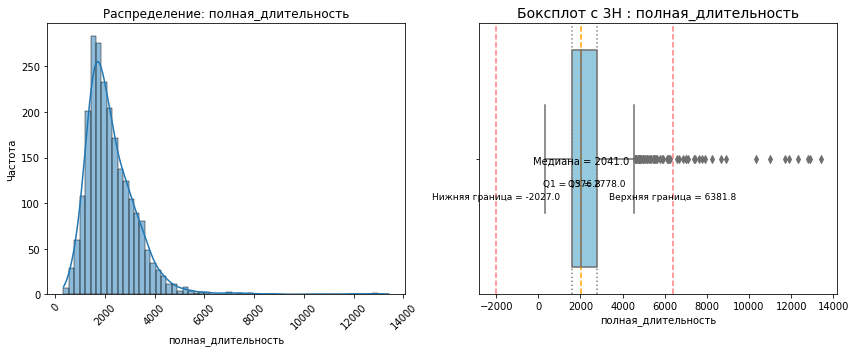

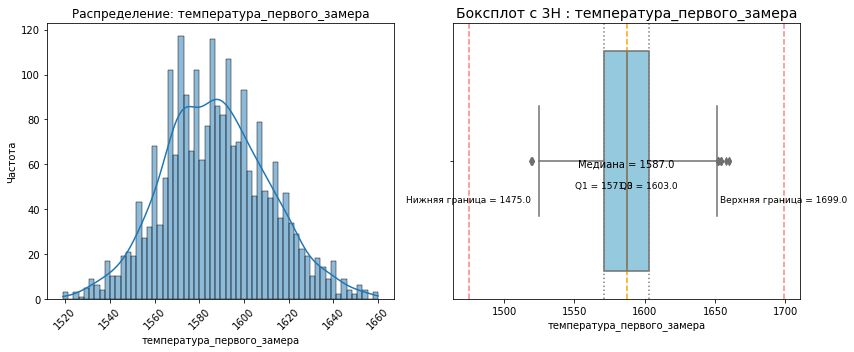

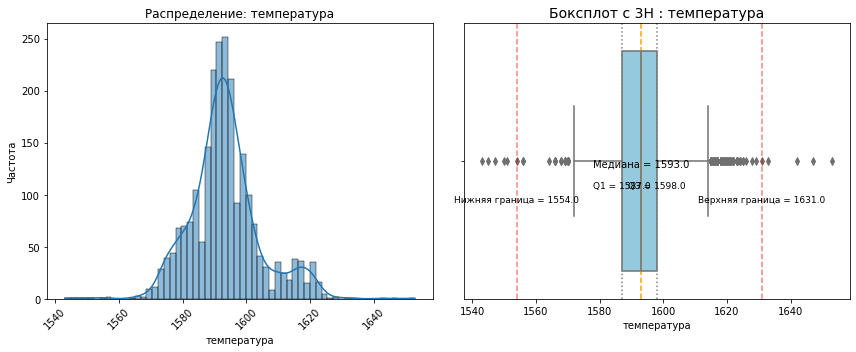

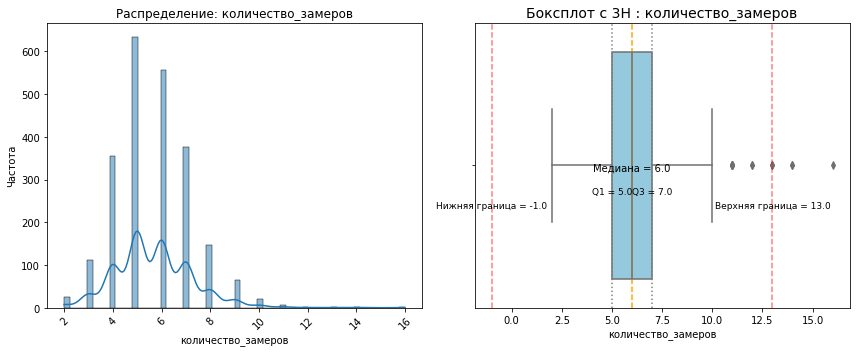

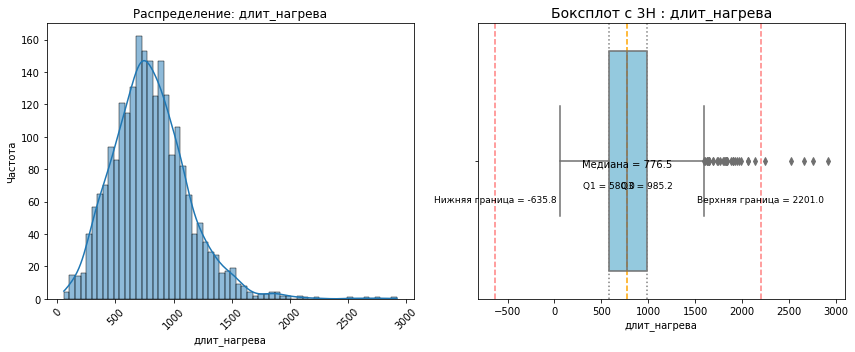

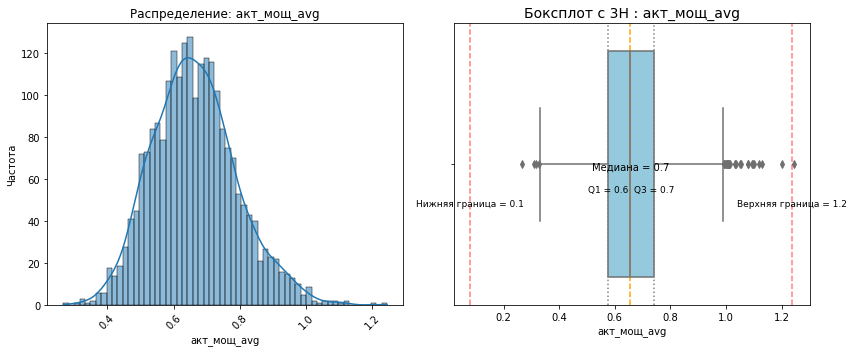

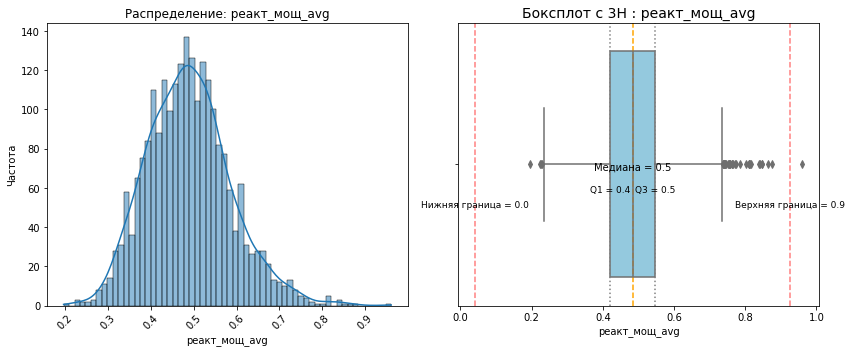

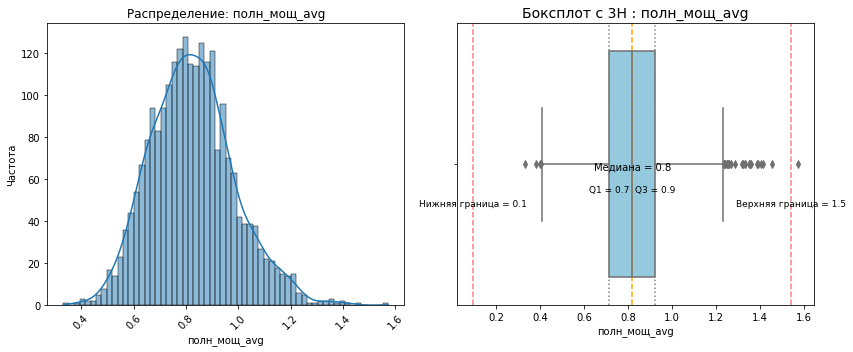

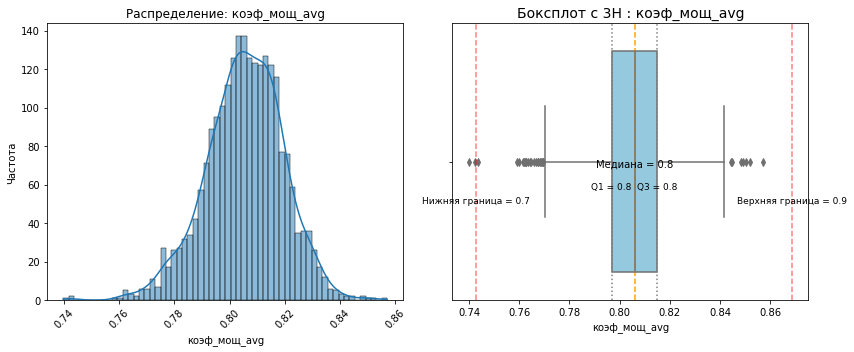

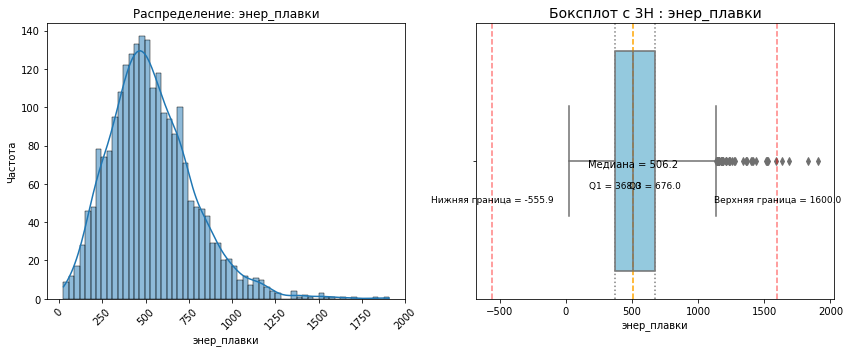

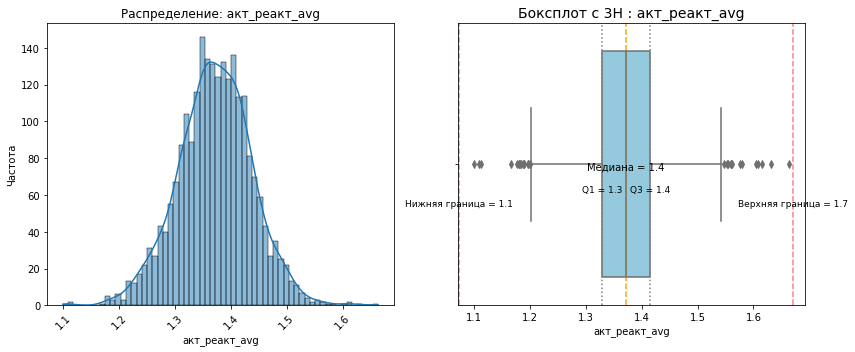

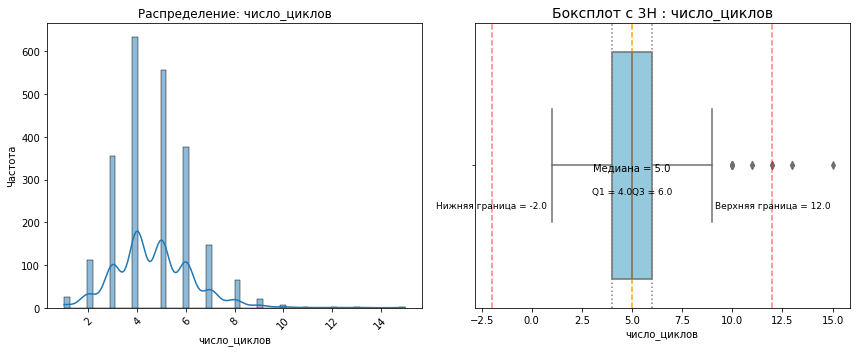

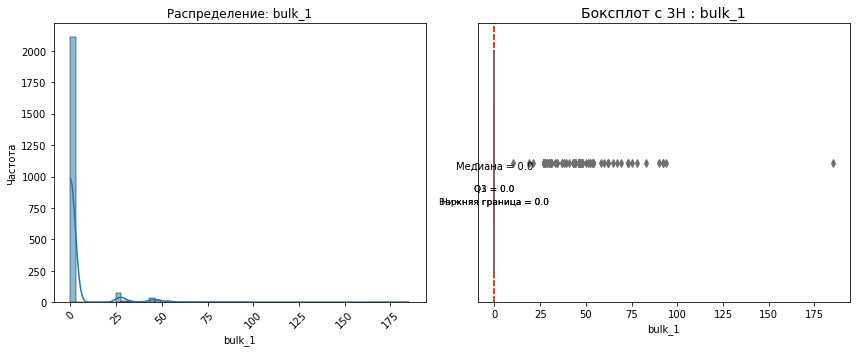

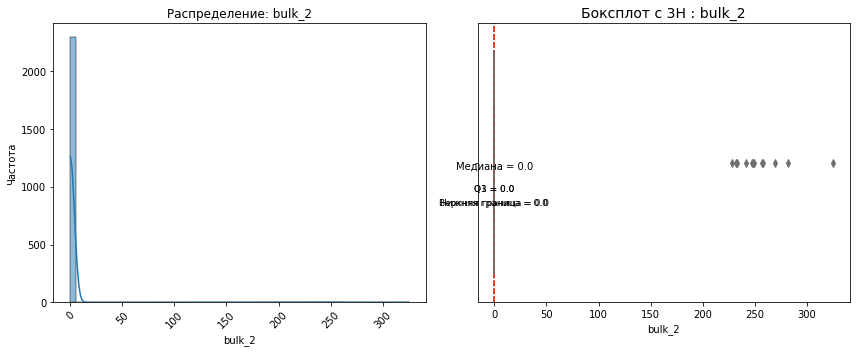

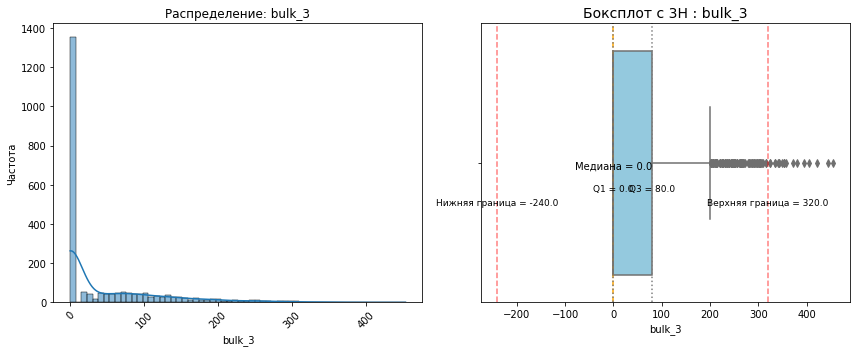

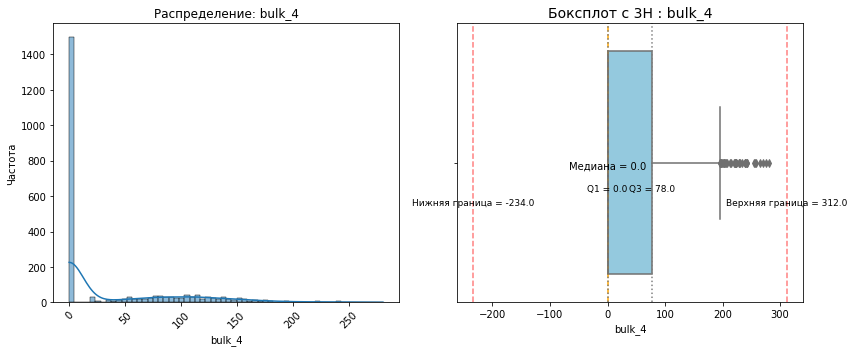

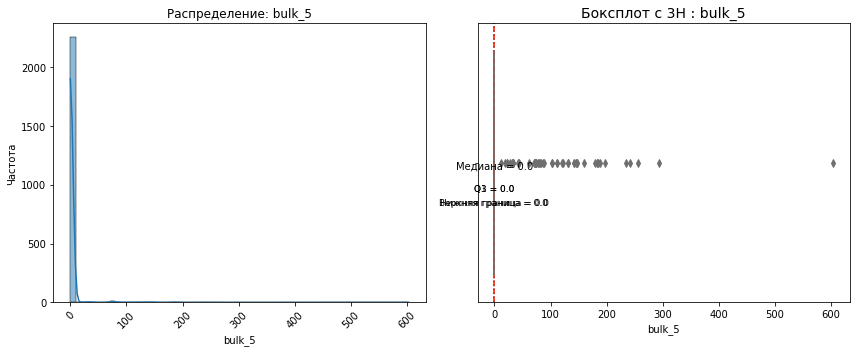

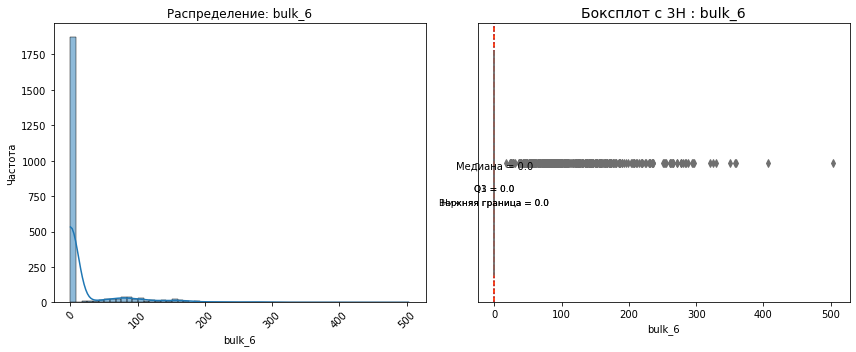

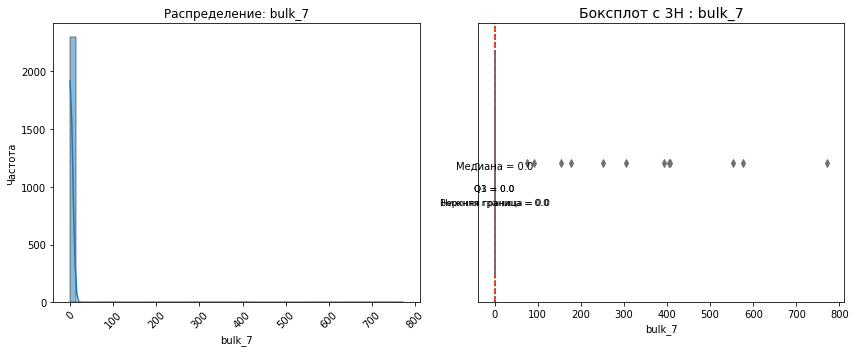

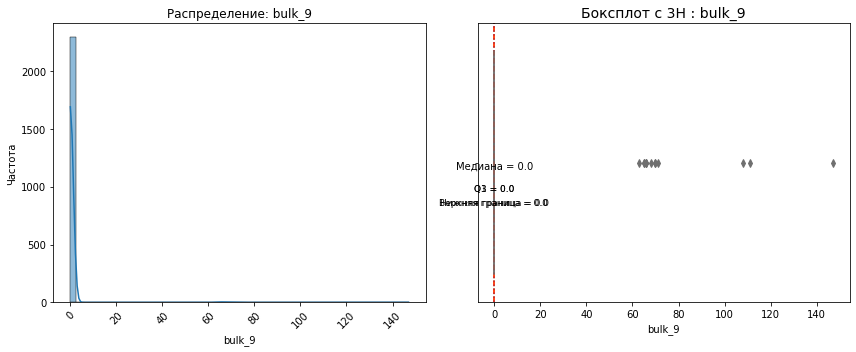

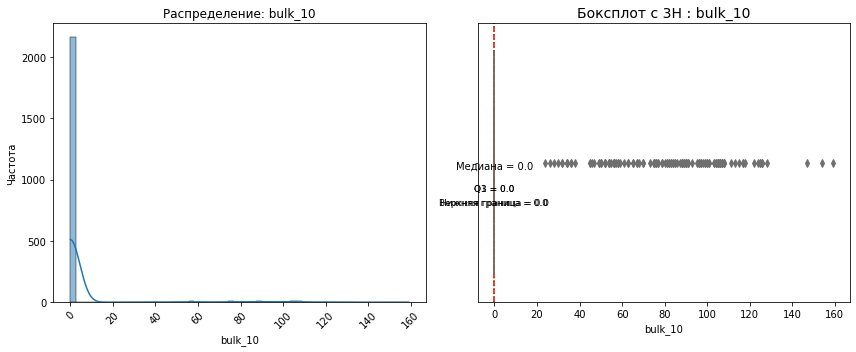

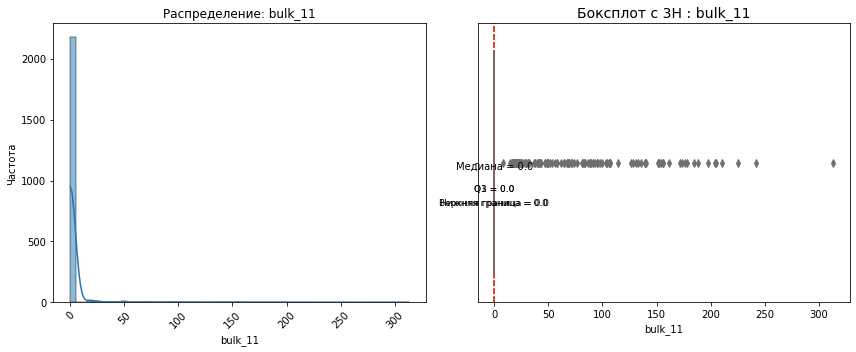

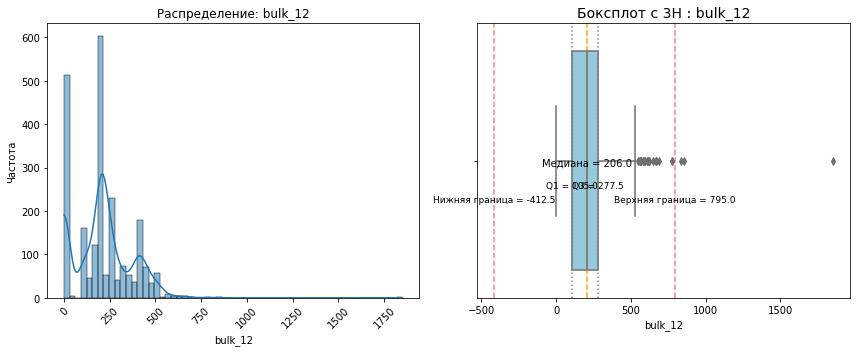

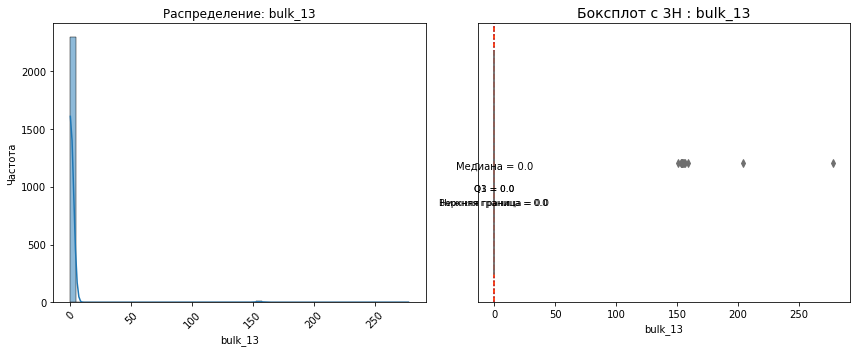

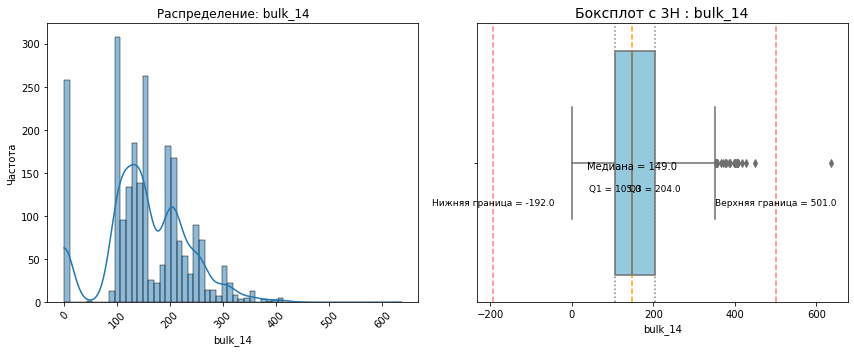

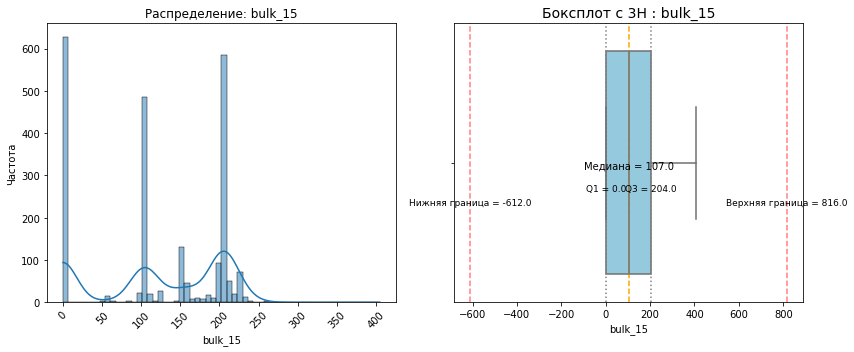

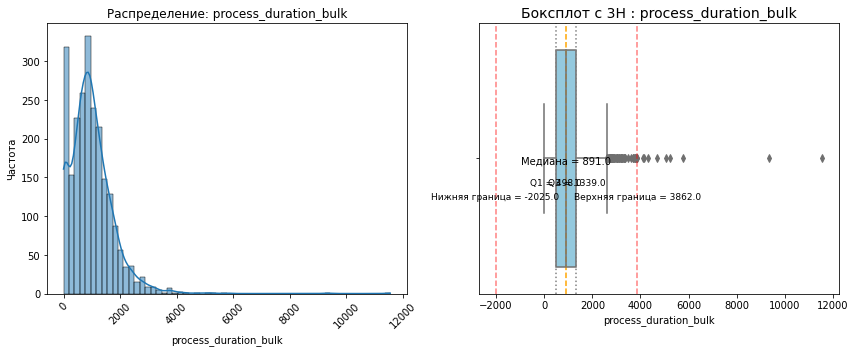

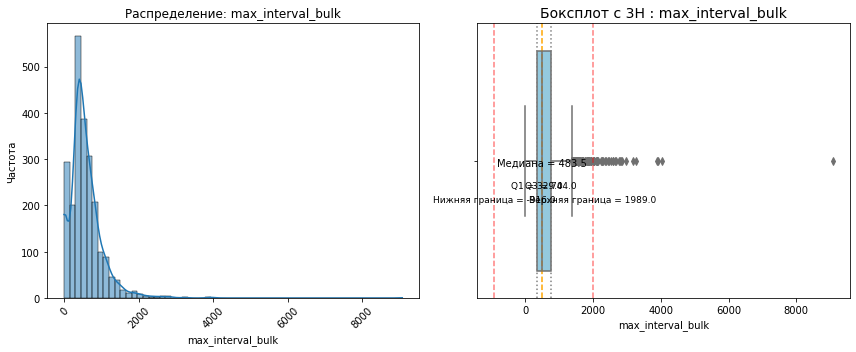

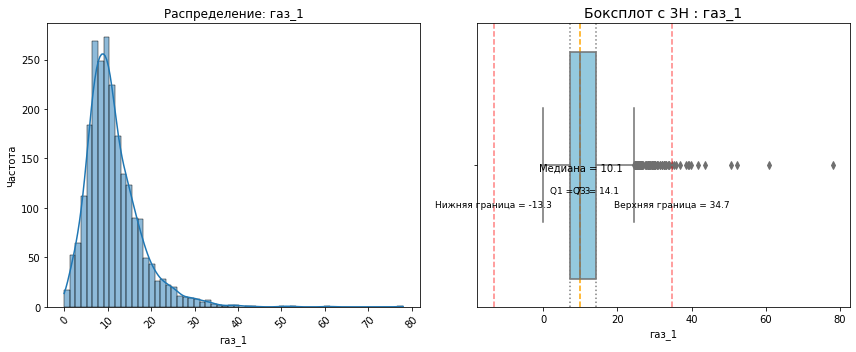

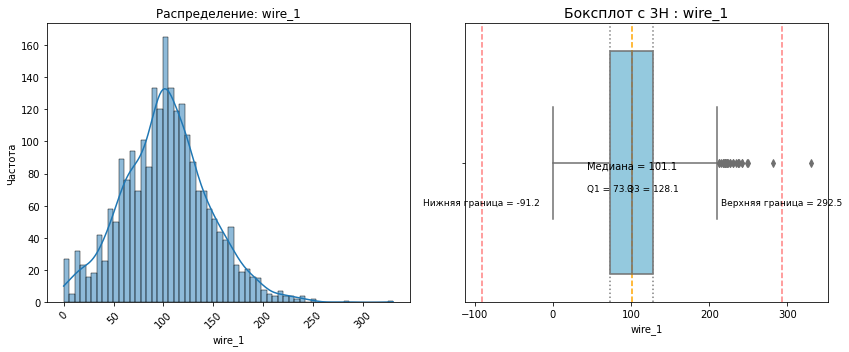

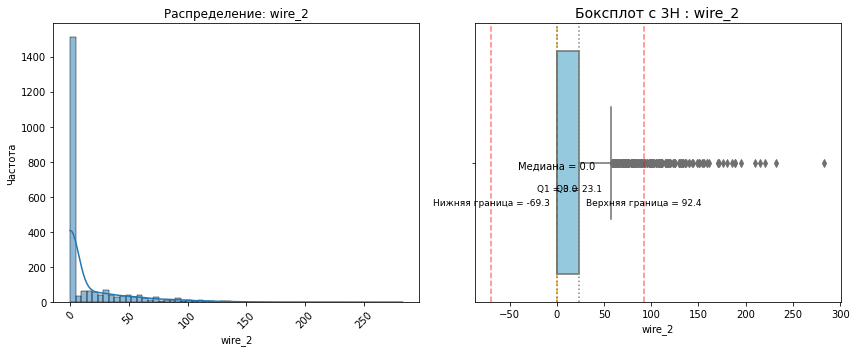

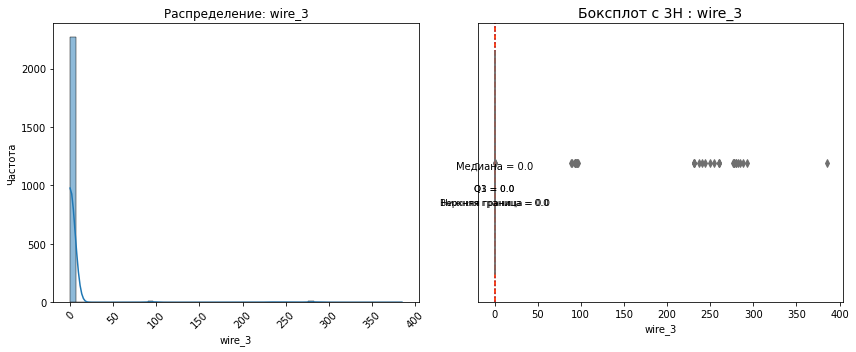

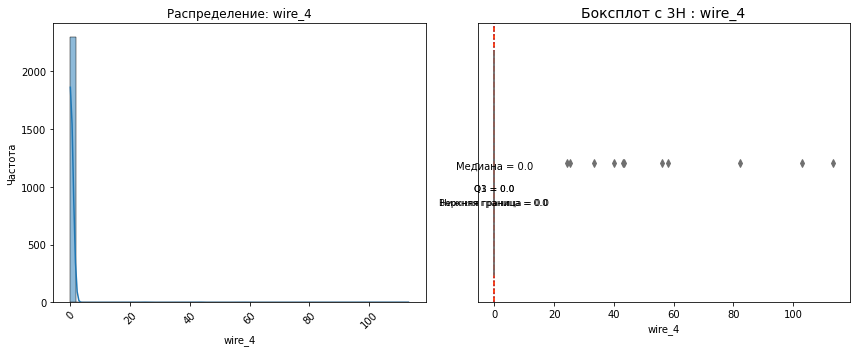

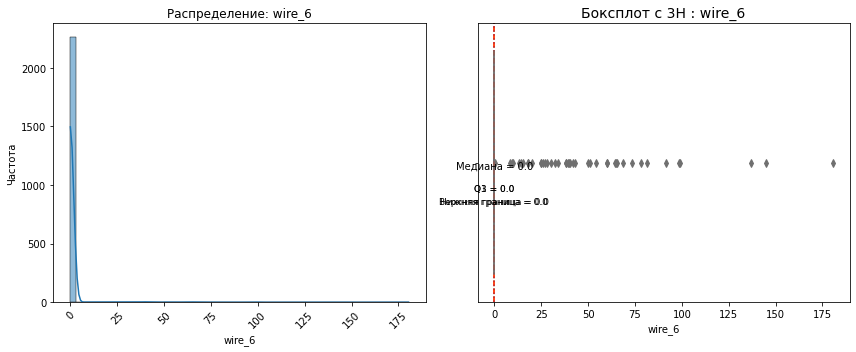

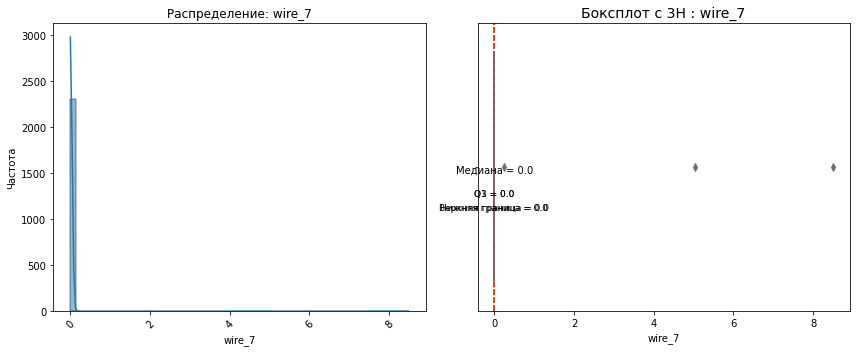

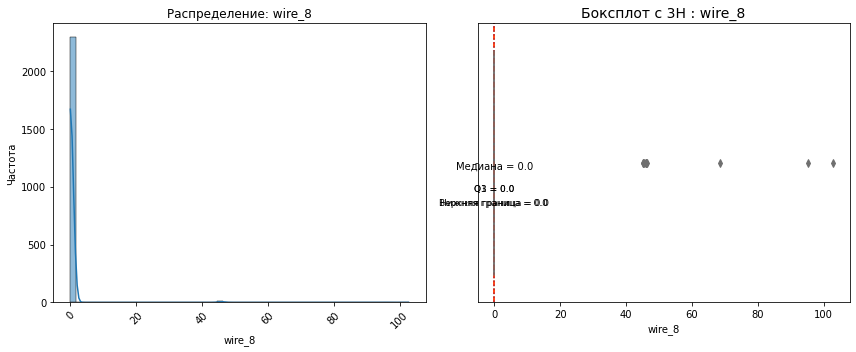

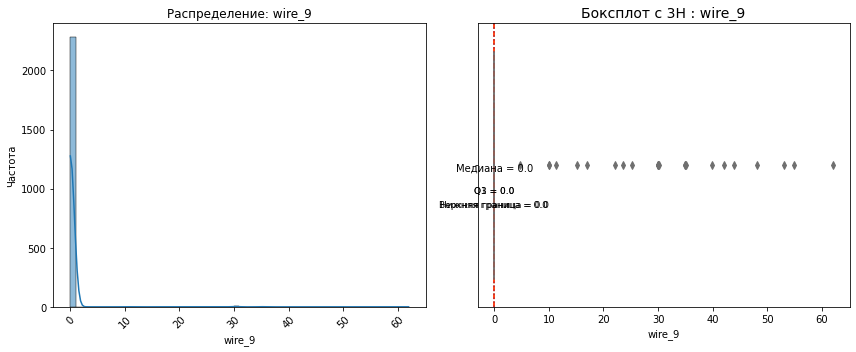

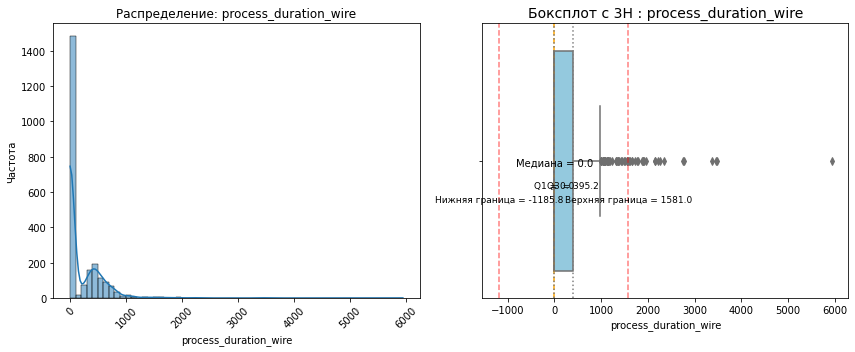

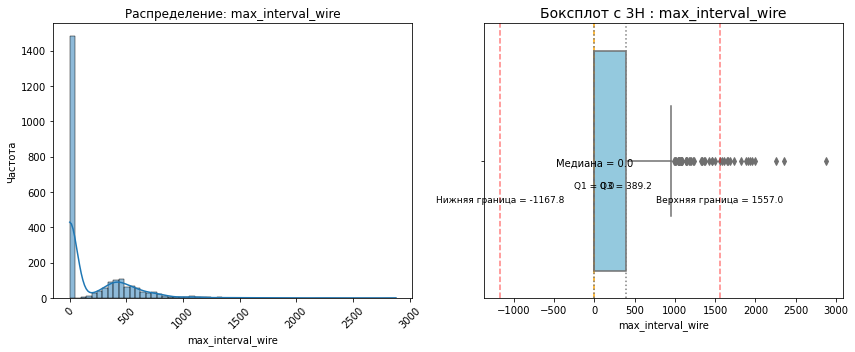

In [137]:
graf(full_df)

 Bulk_12 как-то сильно великоват
 У wire_7 всегонесколько значение, отличных от нуля

 если примерно перевести литры в т 9.25 т — это примерно 9 % от массы ковша, технологически допустимо, если это крупная корректировка состава (например, при первой подаче легирующих).


В итоге после объединения таблиц с признаком wire_7 отличным от 0 у нас осталась только одна строчка. Имеет смысл удалить этот признак

In [138]:
bulk_12_ind = full_df.query('bulk_12>1500').index
full_df = full_df.drop(index=bulk_12_ind)

In [139]:
full_df.drop(columns='wire_7', inplace=True)

In [140]:
full_df.shape

(2307, 38)

Сделаем доп.признаки. Характеристики bulk-добавок

In [141]:
bulk_cols = [c for c in full_df.columns if c.startswith("bulk_")]
if bulk_cols:
    full_df["bulk_total"] = full_df[bulk_cols].sum(axis=1)
    full_df["bulk_mean"] = full_df[bulk_cols].mean(axis=1)
    full_df["bulk_max"] = full_df[bulk_cols].max(axis=1)

Характеристики wire-добавок

In [142]:
wire_cols = [c for c in full_df.columns if c.startswith("wire_")]
if wire_cols:
    full_df["wire_total"] = full_df[wire_cols].sum(axis=1)
    full_df["wire_mean"] = full_df[wire_cols].mean(axis=1)
    full_df["wire_max"] = full_df[wire_cols].max(axis=1)

Отношения добавок между собой

In [143]:
if bulk_cols and wire_cols:
    full_df["wire_to_bulk"] = full_df["wire_total"] / (full_df["bulk_total"] + 1e-6)

## **Корреляционный анализ**

In [144]:
num_col = full_df.select_dtypes(include='number').columns.tolist()
phik_overview = full_df.phik_matrix(interval_cols = num_col)


phik_list = (phik_overview.unstack().sort_values(ascending=False))

# убираем дубликаты и самокорреляции
phik_list = phik_list[(phik_list.index.get_level_values(0) < phik_list.index.get_level_values(1))]

Смотрим признаки мультиколлинеарные между собой

In [145]:
phik_list.head(10)

bulk_9              wire_8           1.000000
количество_замеров  число_циклов     1.000000
wire_mean           wire_total       1.000000
bulk_mean           bulk_total       1.000000
акт_мощ_avg         полн_мощ_avg     0.994586
акт_реакт_avg       коэф_мощ_avg     0.982990
полн_мощ_avg        реакт_мощ_avg    0.980888
bulk_7              wire_4           0.973097
wire_3              wire_max         0.965549
акт_мощ_avg         реакт_мощ_avg    0.962646
dtype: float64

мы видим корреляцию 1 у bulk_9 и wire_8. Попытаемся понять природу такой высокой связи

In [146]:
mask1 = full_df['wire_8'] != 0
mask2 = full_df['bulk_9'] != 0

(mask1 == mask2).all()

True

In [147]:
m_1 =data_wire.query('wire_8 != 0').index
m_2 = data_bulk.query('bulk_9 != 0').index
(m_1 == m_2).all()

True

Все строки совпадают (даже не в объединенном df, а в родных,но почищенных от выбросов), скорее всего wire_8 и bulk_9 связанные процессы

В производстве стали (особенно при легировании в ковше) очень часто:
сыпучие добавки (bulk) и проволочные материалы (wire) вносят в рамках одной операции. Одна добавка может идти в виде кусков сплава, другая — в виде проволоки с тем же элементом, но в другой форме (например, ферросилиций и силикат кальция). Иногда материал подаётся параллельно в двух формах, чтобы ускорить растворение и равномернее распределить элемент.Т.к. wire_8 и bulk_9 активируются строго в одних и тех же партиях, то можно рассматривать их как одну технологическую стадию.
В модель можно включить либо один из них, либо создать новую агрегированную фичу. Создадим агрегированную фичу (интерпретируя -  это даст общий объём материала, поданного на данном этапе).

In [148]:
full_df['wire8_bulk9'] = full_df['wire_8'] + full_df['bulk_9']
full_df.drop(columns=['wire_8','bulk_9'], inplace=True)

In [149]:
full_df.drop(columns=['количество_замеров','wire_mean', 'bulk_mean'], inplace=True)

In [150]:
full_df.columns

Index(['полная_длительность', 'температура_первого_замера', 'температура',
       'длит_нагрева', 'акт_мощ_avg', 'реакт_мощ_avg', 'полн_мощ_avg',
       'коэф_мощ_avg', 'энер_плавки', 'акт_реакт_avg', 'число_циклов',
       'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15',
       'process_duration_bulk', 'max_interval_bulk', 'газ_1', 'wire_1',
       'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_9',
       'process_duration_wire', 'max_interval_wire', 'bulk_total', 'bulk_max',
       'wire_total', 'wire_max', 'wire_to_bulk', 'wire8_bulk9'],
      dtype='object')

акт_реакт_avg и коэф_мощ_avg показывают высокую корреляцию 0.98. Они описывают очень похожие физические явления, просто с разных сторон. акт_реакт_avg — это среднее отношение активной мощности к реактивной Чем больше 𝑃/𝑄, тем более эффективно идёт процесс — больше энергии превращается в тепло, меньше «болтается» в виде реактивной составляющей.коэф_мощ_avg показывает долю активной мощности в общей. Оставим один из этих признаков

In [151]:
full_df.drop(columns=['акт_реакт_avg'], inplace=True)

Смотрим признаки, показывающие минимальную корреляцию с таргетом

In [152]:
phik_with_target = phik_overview['температура'].sort_values(ascending=True)
phik_with_target

wire_to_bulk                  0.000000
bulk_13                       0.000000
bulk_10                       0.000000
bulk_9                        0.000000
wire_8                        0.000000
bulk_3                        0.000000
акт_реакт_avg                 0.000000
wire_9                        0.000000
акт_мощ_avg                   0.000000
реакт_мощ_avg                 0.001810
полн_мощ_avg                  0.019496
коэф_мощ_avg                  0.041777
bulk_11                       0.099991
bulk_max                      0.252082
wire_mean                     0.274141
wire_total                    0.274141
wire_2                        0.279297
bulk_4                        0.291789
количество_замеров            0.300161
число_циклов                  0.300161
bulk_mean                     0.305172
bulk_total                    0.305415
bulk_14                       0.310329
bulk_5                        0.311362
bulk_6                        0.326276
bulk_15                  

активная мощность и полная мощность отражают разные физические величины (полная мощность-векторная сумма акт и реакт мощностей). Мы видим очень высокую взаимосвязь акт и полн мощностей (можно говорить о мультиколлинеарности признаков). При этом таргет с средней акт мощностью выдает нулевую phik корреляцию. Поэтому удалим акт_мощ_avg из списка фичей

In [153]:
full_df.drop(columns=['акт_мощ_avg'], inplace=True)

In [154]:
len(full_df.columns)

39

Итого у нас сейчас 33 признака и таргет. Построим простую baseline модель, с помощью которой оценим важность признаком и откинем еще часть неважных

## **Baseline model**

У нас **регрессионная задача** (температура-таргет) и 33 признака (все числовые). Много технологических параметров (нагрев, легирование, подача газа и т. д.). Есть большой разброс значений и нелинейные зависимости (например, энергия за цикл, добавки, соотношения мощностей). Данные уже предобработаны и агрегированы по партиям.

Процесс плавки стали содержит сложные взаимосвязи — нелинейные и с пороговыми эффектами (например, добавка + газ = синергия). Линейная модель просто не уловит эти зависимости. В качестве опорной точки нам нужна устойчивая модель без ручного подбора параметров. Используем ***RandomForestRegressor*** как реалистичный технологический базлайн. Он не требует масштабирования и устойчив к шуму и выбросам, работает достаточно быстро с таким количеством признаков и объемом датасета. Мы сможем оценить feature importance — какие параметры сильнее влияют на итоговую температуру.


Цель нашей модели предсказать температуру как можно ближе к фактической.
При занижении температуры (недогрев) сталь не достигнет нужных свойств, перегрев - избыточные энергозатраты и разрушение футеровки ковша. Нам критично именно отклонение в градусах — насколько точно предсказываем °C. 
В качестве основной метрики лучше выбрать **MAE** — реальные °C отклонения, легко объяснить и интерпретировать технологам.
Однако полезно также посмотреть:
- RMSE (хорошо показывает, насколько модель «наказывает» сильные ошибки (перегревы/недогревы)). 
- MAPE (mean absolute percentage error) - это ошибка в %, относительно фактической температуры.
- R2 (коэффициент детерминации) - позволяет оценить, насколько модель вообще «понимает физику процесса», насколько хорошо модель объясняет разброс целевого признака (температуры).

Разделяем таргет и данные. Мы не будем выделать валидационный датасет, т.к. используем кросс-валидацию и обучаем baseline

In [155]:
def evaluate_baseline(df, random_state=RANDOM_STATE):
    """
    Оценивает базовую модель RandomForestRegressor с помощью кросс-валидации.
    """
    X = df.drop(columns=['температура'])
    y = df['температура']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    rf = RandomForestRegressor(n_estimators=200, random_state=random_state, n_jobs=-1)
    cv = KFold(n_splits=3, shuffle=True, random_state=random_state)

    r2_scores = cross_val_score(rf, X, y, cv=cv, scoring='r2')
    mae_scores = -cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_absolute_error')
    rmse_scores = np.sqrt(-cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error'))
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    mape_scores = -cross_val_score(rf, X, y, cv=cv, scoring=mape_scorer)

    print("Результаты кросс-валидации (RandomForestRegressor):")
    print(f"MAE:  {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")
    print(f"R²:   {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
    print(f"RMSE: {rmse_scores.mean():.3f} ± {rmse_scores.std():.3f}")
    print(f"MAPE: {mape_scores.mean() * 100:.2f}% ± {mape_scores.std() * 100:.2f}%")

    rf.fit(X_train, y_train)

    return ( {'MAE_mean': mae_scores.mean(),
            'R2_mean': r2_scores.mean(),
            'RMSE_mean': rmse_scores.mean(),
            'MAPE_mean': mape_scores.mean() * 100},
             rf,X, X_test, y_test)

In [156]:
metric1, rf, X, X_test, y_test = evaluate_baseline(full_df)

Результаты кросс-валидации (RandomForestRegressor):
MAE:  6.096 ± 0.136
R²:   0.446 ± 0.016
RMSE: 8.256 ± 0.135
MAPE: 0.38% ± 0.01%


- **MAE** - cредняя ошибка модели составляет около 6 °C при средней температуре 1595 °C . Это очень небольшой разброс относительно технологического диапазона, и для первых приближений вполне приемлемо.

- **R²** - модель объясняет ≈42 % вариации температуры. Значение не очень высокое — значит, есть неучтённые факторы, либо процесс частично случайный. Для производственных данных с шумом это нормальный базовый уровень.

- **RMSE** -усреднённая квадратичная ошибка чуть выше MAE, что нормально. Подчёркивает, что редкие большие ошибки немного влияют на итог, но не критично.

- **MAPE** - ошибка в процентах меньше половины процента. Очень хороший показатель, понятный технологам: «в среднем прогноз точен на 0.38 % от фактической температуры».

**Вывод:** 
Базовый RandomForest уже показывает достаточно точный прогноз температуры для первоначальной оценки. R² относительно невысокий, MAE/RMSE и MAPE показывают, что ошибки небольшие в абсолютных значениях.

Перед тем как переходить к более сложным моделям откинем избыточные признаки

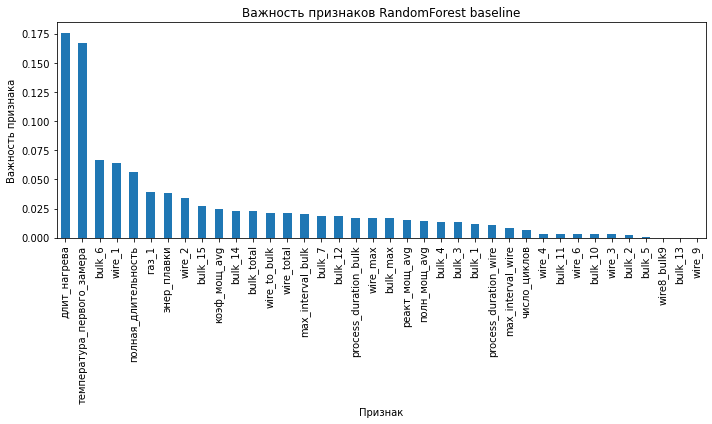

In [157]:
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)


plt.figure(figsize=(10, 6))
feat_imp.plot(kind='bar')
plt.title('Важность признаков RandomForest baseline')
plt.ylabel('Важность признака')
plt.xlabel('Признак')
plt.tight_layout()
plt.show()

Признаки bulk_13, wire_9 и wire8_bulk9 показывают нулевую корреляцию и минимальную важность для модели. Уберем их

In [158]:
full_df1 = full_df.copy()

**Permutation Importance**. Посмотрим признаки, которые мешают

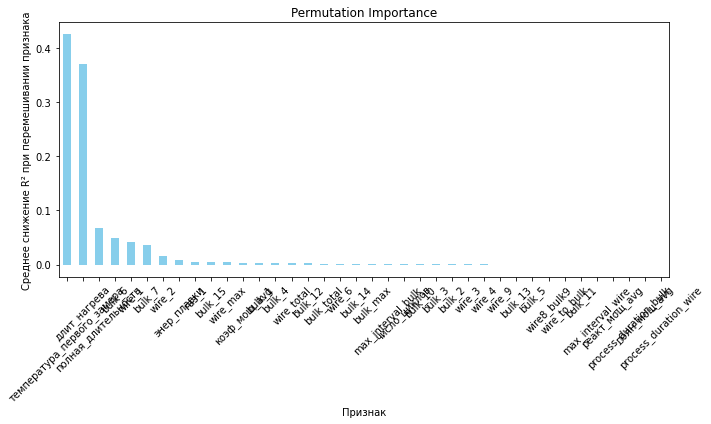

Признак  Permutation Importance
0   температура_первого_замера                0.425799
1                 длит_нагрева                0.369970
2          полная_длительность                0.066911
3                       bulk_6                0.048317
4                       wire_1                0.042048
5                       bulk_7                0.036512
6                       wire_2                0.015771
7                  энер_плавки                0.008938
8                        газ_1                0.005253
9                      bulk_15                0.004609
10                    wire_max                0.004273
11                коэф_мощ_avg                0.003204
12                      bulk_1                0.003029
13                      bulk_4                0.002948
14                  wire_total                0.002902
15                     bulk_12                0.002218
16                  bulk_total                0.001912
17                      wire_6                0.001611
18                     bulk_14                0.001257
19                    bulk_max                0.001225
20           max_interval_bulk                0.001096
21                число_циклов                0.000983
22                     bulk_10                0.000682
23                      bulk_3                0.000626
24                      bulk_2                0.000486
25                      wire_3                0.000423
26                      wire_4                0.000373
27                      wire_9               -0.000005
28                     bulk_13               -0.000013
29                      bulk_5               -0.000014
30                 wire8_bulk9               -0.000063
31                wire_to_bulk               -0.000142
32                     bulk_11               -0.000195
33           max_interval_wire               -0.000610
34               реакт_мощ_avg               -0.000734
35       process_duration_bulk               -0.000987
36                полн_мощ_avg               -0.001021
37       process_duration_wire               -0.001265

In [159]:
perm_importance = permutation_importance(rf,X_test, y_test, n_repeats=10, random_state=RANDOM_STATE,n_jobs=-1)


feat_imp_perm = pd.Series(perm_importance.importances_mean, index=X_test.columns).sort_values(ascending=False)


plt.figure(figsize=(10, 6))
feat_imp_perm.plot(kind='bar', color='skyblue')
plt.title('Permutation Importance')
plt.ylabel('Среднее снижение R² при перемешивании признака')
plt.xlabel('Признак')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


feat_imp_table = feat_imp_perm.reset_index()
feat_imp_table.columns = ['Признак', 'Permutation Importance']
feat_imp_table

In [160]:
threshold = 0.001

useless_features = feat_imp_perm[feat_imp_perm < threshold].index.tolist()

print("Бесполезные признаки:")
print(useless_features)

Бесполезные признаки:
['число_циклов', 'bulk_10', 'bulk_3', 'bulk_2', 'wire_3', 'wire_4', 'wire_9', 'bulk_13', 'bulk_5', 'wire8_bulk9', 'wire_to_bulk', 'bulk_11', 'max_interval_wire', 'реакт_мощ_avg', 'process_duration_bulk', 'полн_мощ_avg', 'process_duration_wire']


Уберем:

- wire8_bulk9 (отрицательное perm imp, минимальное feature imp, если пересчитать корреляцию с этим комбинированным пизнаком она нулевая)
- bulk_2 (он показывает высокую корреляцию с таргетом, однако на feature imp значение низкое а на perm imp вообще отрицательное)
- полн_мощ_avg (отрицательное perm imp, невысокая feature imp, низкая корреляция)

'process_duration_bulk' пока не будем убирать, несмотря на отрицательное значение  perm imp. Оно показывает не самое маленькое значение на feature imp и довольно высокую корреляцию с таргетом. Т.к. Permutation Importance рассматривает только одельный вклад признака, а не его взаимодейстьвие с другими, то нельзя ориентироваться только на этот показатель

In [161]:
full_df1 = full_df1.drop(columns=useless_features)

In [162]:
full_df1.columns

Index(['полная_длительность', 'температура_первого_замера', 'температура',
       'длит_нагрева', 'коэф_мощ_avg', 'энер_плавки', 'bulk_1', 'bulk_4',
       'bulk_6', 'bulk_7', 'bulk_12', 'bulk_14', 'bulk_15',
       'max_interval_bulk', 'газ_1', 'wire_1', 'wire_2', 'wire_6',
       'bulk_total', 'bulk_max', 'wire_total', 'wire_max'],
      dtype='object')

Сравним ухудшилась ли метрика после удаления фичей:

In [163]:
metric2, rf, X, X_test, y_test = evaluate_baseline(full_df1)

Результаты кросс-валидации (RandomForestRegressor):
MAE:  6.044 ± 0.138
R²:   0.456 ± 0.011
RMSE: 8.185 ± 0.104
MAPE: 0.38% ± 0.01%


In [164]:
metric1

{'MAE_mean': 6.09587993064586,
 'R2_mean': 0.44628513415335685,
 'RMSE_mean': 8.256180555464075,
 'MAPE_mean': 0.38211382484568956}

In [165]:
len(full_df1.columns)

22

хуже не стало, убрали 8 признаков

## **Подбор модели с гиперпараметрами**

In [166]:
full_df1.head()

полная_длительность  температура_первого_замера  температура  \
key                                                                 
1                 1714.0                      1571.0       1613.0   
2                 1265.0                      1581.0       1602.0   
3                 1753.0                      1596.0       1599.0   
4                 1220.0                      1601.0       1625.0   
5                 1536.0                      1576.0       1602.0   

     длит_нагрева  коэф_мощ_avg  энер_плавки  bulk_1  bulk_4  bulk_6  bulk_7  \
key                                                                            
1          1098.0      0.816686   628.616930     0.0    43.0     0.0     0.0   
2           811.0      0.825276   395.281800     0.0    73.0     0.0     0.0   
3           655.0      0.809724   581.774624     0.0    34.0     0.0     0.0   
4           741.0      0.793923   543.710274     0.0    81.0     0.0     0.0   
5           869.0      0.796818   412.180480     0.0    78.0     0.0     0.0   

     ...  bulk_15  max_interval_bulk      газ_1     wire_1   wire_2  wire_6  \
key  ...                                                                      
1    ...    154.0              581.0  29.749986  60.059998  0.00000     0.0   
2    ...    154.0              469.0  12.555561  96.052315  0.00000     0.0   
3    ...    153.0              372.0  28.554793  91.160157  0.00000     0.0   
4    ...    154.0              409.0  18.841219  89.063515  0.00000     0.0   
5    ...    152.0              205.0   5.413692  89.238236  9.11456     0.0   

     bulk_total  bulk_max  wire_total   wire_max  
key                                               
1         553.0     206.0   60.059998  60.059998  
2         582.0     206.0   96.052315  96.052315  
3         544.0     205.0   91.160157  91.160157  
4         595.0     207.0   89.063515  89.063515  
5         584.0     203.0   98.352796  89.238236  

[5 rows x 22 columns]

In [167]:
X = full_df1.drop(columns=['температура'])
y = full_df1['температура']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=RANDOM_STATE)

Для сравнения посмотрим скоринг у дамми-модели

In [168]:
dummy = DummyRegressor(strategy='mean')

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

mae_dummy = -cross_val_score(dummy, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
rmse_dummy = np.sqrt(-cross_val_score(dummy, X_train, y_train, cv=cv, scoring='neg_mean_squared_error'))
r2_dummy = cross_val_score(dummy, X_train, y_train, cv=cv, scoring='r2')
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_dummy = -cross_val_score(dummy, X_train, y_train, cv=cv, scoring=mape_scorer)

print("=== Дамми-модель ===")
print(f"MAE:  {mae_dummy.mean():.3f} ± {mae_dummy.std():.3f}")
print(f"RMSE: {rmse_dummy.mean():.3f} ± {rmse_dummy.std():.3f}")
print(f"R²:   {r2_dummy.mean():.3f} ± {r2_dummy.std():.3f}")
print(f"MAPE: {mape_dummy.mean() * 100:.2f}% ± {mape_dummy.std() * 100:.2f}%")

=== Дамми-модель ===
MAE:  7.969 ± 0.088
RMSE: 11.036 ± 0.064
R²:   -0.003 ± 0.002
MAPE: 0.50% ± 0.01%


Т.к. у нас нет категориальных признаков, то катбуст брать не будем. Оценим модели случайного леса, лайт буста и X бустинг.Ради интереса используем как контроль линейную модель, чтобы оценить, есть ли сильная нелинейность. И сравним с нейросетью

Соберем пайплайн для моделей. Скалируем только для линейной модели, для ансамблев деревьев скейлинг не нужен и добавляет только лишние операции

In [169]:
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [170]:
pipelines = {'RandomForest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))]),
    
    'XGBoost': Pipeline([('scaler', StandardScaler()),
        ('model', XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, objective='reg:squarederror'))]),
    
    'LightGBM': Pipeline([('scaler', StandardScaler()),
        ('model', lgb.LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1))]),
    
    'Ridge': Pipeline([('scaler', StandardScaler()),
        ('model', Ridge())])}

param_grids_pipeline = {
'RandomForest': {'model__n_estimators': [100, 200, 300, 500],
                 'model__max_depth': [10, 20, 25],
                 'model__min_samples_split': [ 6, 8, 9],
                 'model__min_samples_leaf': [1, 2, 4]},
    
    'XGBoost': {'model__n_estimators': [150, 200, 300],
                'model__learning_rate': [0.005, 0.01, 0.05],
                'model__max_depth': [2, 3, 5, 7]},
    
    'LightGBM': {'model__n_estimators': [ 150, 200, 300],
                 'model__learning_rate': [0.02, 0.05, 0.08],
                 'model__max_depth': [4, 5, 6],
                 'model__num_leaves': [21, 31, 43]},
    
    'Ridge': {'model__alpha': [8, 9, 10]}}

def run_random_search_pipeline(model_name, pipeline, param_grid, X, y, n_iter=20):
    rs = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring='neg_mean_absolute_error',
        cv=KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
        n_jobs=-1,
        verbose=1)
    
    rs.fit(X, y)
    best_model = rs.best_estimator_
    
    print(f"\nЛучшие параметры для {model_name}: {rs.best_params_}")
    print(f"Лучший MAE: {-rs.best_score_:.3f}")
    
    # Кросс-валидация для всех метрик
    cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    
    mae_scores = -cross_val_score(best_model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(best_model, X, y, cv=cv, scoring='r2')
    rmse_scores = np.sqrt(-cross_val_score(best_model, X, y, cv=cv, scoring='neg_mean_squared_error'))
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    mape_scores = -cross_val_score(best_model, X, y, cv=cv, scoring=mape_scorer)
    
    metrics = {'MAE_mean': mae_scores.mean(),
        'MAE_std': mae_scores.std(),
        'R2_mean': r2_scores.mean(),
        'R2_std': r2_scores.std(),
        'RMSE_mean': rmse_scores.mean(),
        'RMSE_std': rmse_scores.std(),
        'MAPE_mean': mape_scores.mean() * 100,
        'MAPE_std': mape_scores.std() * 100}
    
    return best_model, metrics

In [171]:
models = ['RandomForest', 'XGBoost', 'LightGBM', 'Ridge']
results = {}

for m in models:
    best_model, metrics = run_random_search_pipeline(
        model_name=m,
        pipeline=pipelines[m],
        param_grid=param_grids_pipeline[m],
        X=X_train,
        y=y_train,
        n_iter=80)
    results[m] = {'model': best_model, 'metrics': metrics}

Fitting 3 folds for each of 80 candidates, totalling 240 fits

Лучшие параметры для RandomForest: {'model__n_estimators': 200, 'model__min_samples_split': 6, 'model__min_samples_leaf': 2, 'model__max_depth': 25}
Лучший MAE: 6.040


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 36 is smaller than n_iter=80. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 36 candidates, totalling 108 fits

Лучшие параметры для XGBoost: {'model__n_estimators': 300, 'model__max_depth': 3, 'model__learning_rate': 0.05}
Лучший MAE: 5.784
Fitting 3 folds for each of 80 candidates, totalling 240 fits

Лучшие параметры для LightGBM: {'model__num_leaves': 43, 'model__n_estimators': 300, 'model__max_depth': 4, 'model__learning_rate': 0.05}
Лучший MAE: 5.809


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 3 is smaller than n_iter=80. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits

Лучшие параметры для Ridge: {'model__alpha': 9}
Лучший MAE: 5.881


В качестве лучшей модели выберем XGboost. Но сначала проверим нейросеть

## **Нейросеть**

У нас задача регрессии, все признаки числовые. Используем полносвязную сеть (MLP). Мы хотим быстро прикинуть и сравнить с другими моделями, поэтому будем использовать keras , а не pyTorch

Подготовка данных

In [172]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1))

Определяем модель Keras (MLP)

In [173]:
def build_model(input_dim, lr=0.0005):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1)])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae'])
    return model

In [175]:
kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

mae_scores, r2_scores, rmse_scores, mape_scores = [], [], [], []

for train_idx, val_idx in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train_scaled[train_idx], y_train_scaled[val_idx]

    model = build_model(X_train_fold.shape[1])
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=20, restore_best_weights=True)

   
    model.fit(X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=200,
        batch_size=16,
        verbose=0,
        callbacks=[early_stop])

 
    y_pred_scaled = model.predict(X_val_fold)

  
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_val_fold)

    
    mae_scores.append(mean_absolute_error(y_true, y_pred))
    r2_scores.append(r2_score(y_true, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_true, y_pred)))
    mape_scores.append(mean_absolute_percentage_error(y_true, y_pred))

print("=== Результаты кросс-валидации Keras MLP ===")
print(f"MAE:  {np.mean(mae_scores):.3f} ± {np.std(mae_scores):.3f}")
print(f"R²:   {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
print(f"RMSE: {np.mean(rmse_scores):.3f} ± {np.std(rmse_scores):.3f}")
print(f"MAPE: {np.mean(mape_scores)*100:.2f}% ± {np.std(mape_scores)*100:.2f}%")

2025-11-12 23:42:23.872245: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


=== Результаты кросс-валидации Keras MLP ===
MAE:  5.673 ± 0.247
R²:   0.505 ± 0.038
RMSE: 7.746 ± 0.339
MAPE: 0.36% ± 0.02%


## **Сравнительная таблица, выбор лучшей модели**

In [176]:
# Собираем данные в словарь. Dummy
all_results = {
    'Dummy': {'MAE': mae_dummy.mean(),
              'MAE_std': mae_dummy.std(),
              'RMSE': rmse_dummy.mean(),
              'RMSE_std': rmse_dummy.std(),
              'R2': r2_dummy.mean(),
              'R2_std': r2_dummy.std(),
              'MAPE': mape_dummy.mean() * 100,
              'MAPE_std': mape_dummy.std() * 100}}

# классические модели 
for model_name in results.keys():
    all_results[model_name] = {'MAE': results[model_name]['metrics']['MAE_mean'],
                               'MAE_std': results[model_name]['metrics']['MAE_std'],
                               'RMSE': results[model_name]['metrics'].get('RMSE_mean', np.nan),
                               'RMSE_std': results[model_name]['metrics'].get('RMSE_std', np.nan),
                               'R2': results[model_name]['metrics']['R2_mean'],
                               'R2_std': results[model_name]['metrics']['R2_std'],
                               'MAPE': results[model_name]['metrics']['MAPE_mean'],
                               'MAPE_std': results[model_name]['metrics']['MAPE_std']}

# Keras MLP
all_results['Keras MLP'] = {'MAE': np.mean(mae_scores),
                            'MAE_std': np.std(mae_scores),
                            'RMSE': np.mean(rmse_scores),        
                            'RMSE_std': np.std(rmse_scores),
                            'R2': np.mean(r2_scores),
                            'R2_std': np.std(r2_scores),
                            'MAPE': np.mean(mape_scores) * 100,
                            'MAPE_std': np.std(mape_scores) * 100}


df_comparison = pd.DataFrame(all_results).T 
df_comparison = df_comparison[['MAE', 'MAE_std', 'RMSE', 'RMSE_std', 'R2', 'R2_std', 'MAPE', 'MAPE_std']]


df_comparison = df_comparison.round(2)

df_comparison

MAE  MAE_std   RMSE  RMSE_std    R2  R2_std  MAPE  MAPE_std
Dummy         7.97     0.09  11.04      0.06 -0.00    0.00  0.50      0.01
RandomForest  6.04     0.14   8.26      0.07  0.44    0.00  0.38      0.01
XGBoost       5.78     0.21   7.82      0.21  0.50    0.02  0.36      0.01
LightGBM      5.81     0.19   7.91      0.10  0.48    0.01  0.36      0.01
Ridge         5.88     0.06   7.82      0.03  0.50    0.01  0.37      0.00
Keras MLP     5.67     0.25   7.75      0.34  0.51    0.04  0.36      0.02

Судя по кросс-валидации,**Keras MLP**  показывает лучший баланс метрик: самая **низкая MAE и RMSE, а также высокое R² (0.48)**, но очень близкий с **XGBoost**

Другие модели (RandomForest, LightGBM, Ridge) близки по точности, но XGBoost немного лучше по ошибке предсказания и стабильности (**меньше стандартное отклонение**).

**Вывод**: для этой задачи регрессии температуры металла оптимально использовать либо Keras MLP либо XGBoost в качестве основной модели. Остальные модели могут служить для контроля или ансамблирования.

**Считаем тест**

Т.к. мы не смогли выбрать между XGBoost и Keras MLP посчитает тест на обеих моделях (просто чтобы убедиться, что они действиительно одинаково улавливают зависимости и выдают более менее честный скоринг)

In [178]:
xgb_model = results['XGBoost']['model']


y_pred = xgb_model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # в процентах

print('XGBoost на тесте')
print(f'MAE:  {mae:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'R²:   {r2:.3f}')
print(f'MAPE: {mape:.2f}%')

XGBoost на тесте
MAE:  6.229
RMSE: 8.295
R²:   0.464
MAPE: 0.39%


In [177]:
final_model = build_model(X_train_scaled.shape[1])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = final_model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=16,
    verbose=0,
    callbacks=[early_stop])


y_pred_scaled = final_model.predict(X_test_scaled)


y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)


mae_test = mean_absolute_error(y_true, y_pred)
r2_test = r2_score(y_true, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_true, y_pred))
mape_test = mean_absolute_percentage_error(y_true, y_pred)

print("\n=== Метрики на тестовой выборке ===")
print(f"MAE:  {mae_test:.3f}")
print(f"R²:   {r2_test:.3f}")
print(f"RMSE: {rmse_test:.3f}")
print(f"MAPE: {mape_test*100:.2f}%")


=== Метрики на тестовой выборке ===
MAE:  6.224
R²:   0.470
RMSE: 8.247
MAPE: 0.39%


Вывод: результаты на тесте близки к метрикам на трейне. Как и в трейне Keras MLP и XGBoost показывают очень близкий результат. Модели работают стабильно, без переобучения. В целом метрики неплохие, но R2 можно было бы улучшить - модель объясняет ~47% дисперсии данных. 

В качестве основной модели остановим свой выбор на XGBoost и проведем анализ остатков

## **Анализ остатков**

In [179]:
residuals = y_test - y_pred

**Распределение остатков**

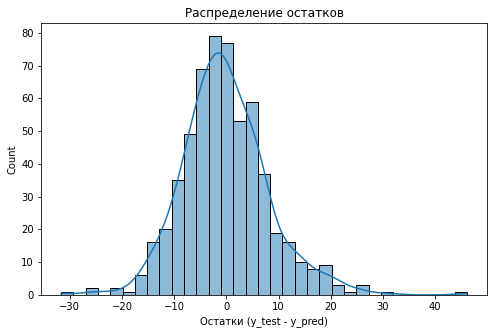

In [180]:
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title("Распределение остатков")
plt.xlabel("Остатки (y_test - y_pred)")
plt.show()


Гистограмма распределия остатков близка к симметрии, чуть смещена влево относительно нуля. Модель немного систематически переоценивает температуру.

**Остатки vs Предсказания**

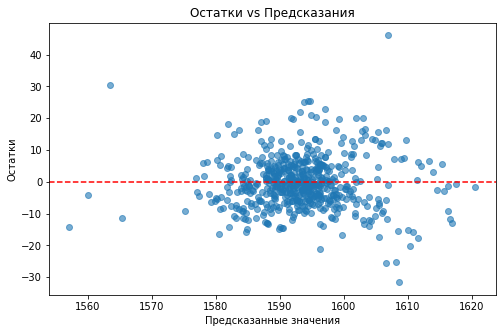

In [181]:
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Предсказанные значения")
plt.ylabel("Остатки")
plt.title("Остатки vs Предсказания")
plt.show()

Точки распределены вокруг нулевой линии, без чёткой структуры. Значит модель не систематически ошибается: нет заметного наклона вверх или вниз. Есть очень небольшое смещение вниз - средняя линия ошибок чуть ниже нуля. Это значит, что модель слегка переоценивает значения (предсказывает немного выше реального в среднем), что мы наблюдали и на гистограмме.
Также есть выброс ниже -30 и выше 40 - возможно, это аномальные наблюдения.
Облако точек выглядит относительно равномерным по оси X (предсказанные значения), что говорит о гомоскедастичности - дисперсия ошибок примерно одинакова для всех уровней прогнозов.

**Остатки vs Истинные значения**

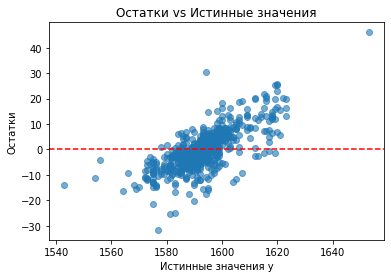

In [182]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Истинные значения y")
plt.ylabel("Остатки")
plt.title("Остатки vs Истинные значения")
plt.show()

этот график показывает интересную закономерность. В идеале точки должны быть случайно разбросаны вокруг горизонтальной линии y=0, без чётких закономерностей. На нашем графике мы видим восходящую косую линию,направленную вверх. 

Остатки явно зависят от истинных значений: при увеличении y_test остатки становятся всё больше (положительные).
При низких истинных значениях (y ≈ 1550-1580) - остатки в основном отрицательные. При высоких (y ≈ 1600-1620) - наоборот, положительные.

Систематическая ошибка модели:
Модель недооценивает большие значения и переоценивает маленькие: модель сглаживает разброс - старается "усреднить" прогнозы и не улавливает крайние значения.

Это говорит о том, что текущая модель не полностью захватывает форму зависимости между признаками и целевой переменной, вероятно, из-за её нелинейного характера или недостаточной глубины модели.

**Q–Q plot (проверка нормальности остатков)**

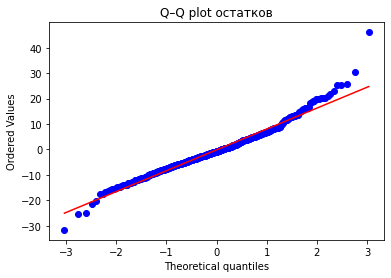

In [183]:

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q–Q plot остатков")
plt.show()

Данные лежат примерно на линии, есть небольшие отклонения на хвостах, они допустимы. Данные хорошо соответствуют нормальному распределению.

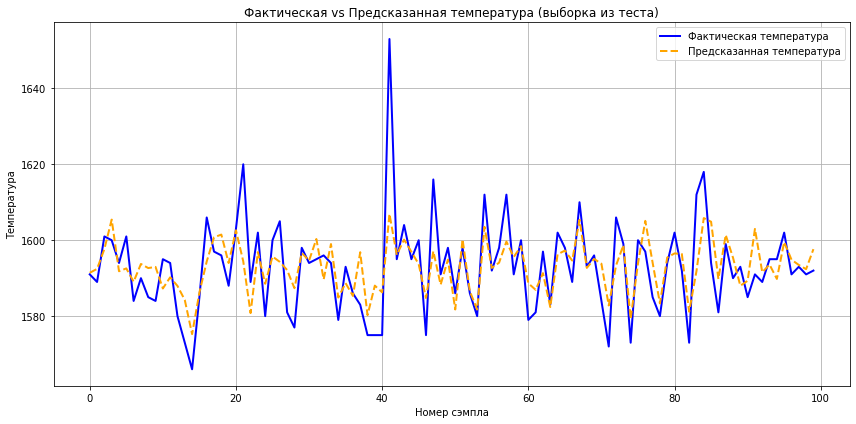

In [184]:
rng = np.random.RandomState(RANDOM_STATE)
sample_size = min(100, len(X_test))
idx = rng.choice(len(X_test), size=sample_size, replace=False)


sample_df = pd.DataFrame({'y_true': np.asarray(y_test).reshape(-1)[idx],
    'y_pred': np.asarray(y_pred).reshape(-1)[idx]})


x_sample = np.arange(len(sample_df))


plt.figure(figsize=(12, 6))
plt.plot(x_sample, sample_df['y_true'], label='Фактическая температура', color='blue', linewidth=2)
plt.plot(x_sample, sample_df['y_pred'], label='Предсказанная температура', color='orange', linestyle='--', linewidth=2)

plt.xlabel("Номер сэмпла")
plt.ylabel("Температура")
plt.title("Фактическая vs Предсказанная температура (выборка из теста)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

В целом похоже, но хочется точнее. Общуюю закономерность модель улавливает, но некоторые предсказания выбиваются довольно сильно (на десяток градусов)

## **Вывод**

Для оптимизации производственных расходов заказчик попросил разработать модель, определяющую температуру сплава на выходе. Модель будет использоваться для имитации технологического процесса.

Нам даны были данные в виде нескольких таблиц в СУБД Sqlite. Для построения модели были выполнены следующие шаги:

- *Загрузка библиотек и данных*. Установили необходимые библиотеки, подключились к базе данных в Sqlite. Проверили все ли заявленные таблицы содержат данные и приступили к выкачке. В итоге весь исследовательский анализ мы провели в пандас, т.к. размер таблиц был не большой и особых условий,позволяющих ограничить выборку при скачивании, не было

- Далее была выполена *предобработка данных*. Названия столбцов переведены в snake_case, проведена проверка на полные дубликаты, рассмотрены по отдельности каждая таблица (оценка общих сведений(info): размер датафрейма, кол-во попусков, тип данных). Приведены типы данных, в некотрых таблицах сформированы дополнительные признаки, которые могут быть информативны при EDA.

- *Исследовательский анализ данных*
Для каждой таблицы отдельно рассмотрели описательную статистику, заполнили или удалили пропуски, визуализировали распредение данных на гистограмме и боксплоте и оценили выбросы (сверяясь со справочной информацией, не только по стаистике и боксплотам).

- *объединили таблицы* в соответствии с условиями:

каждой партии должно соответствовать одно наблюдение, во все партии точно добавлялись сыпучие и проволочные материалы, везде была выполнена продувка газом и сплав всегда нагревался.
При объединении сгенерили аггрегационные признаки.

- выполнили *корреляционный анализ* признаков. Устранили мультиколлинеарность, убрали некоторые признаки с нулевой корреляцией

- в качестве *baseline* модели выбрали RandomForestRegressor - простую модель, способную уловить нелинейные зависимости. По данным базлайна оценили feature importance, permutation importance и исходя из результатов отобрали наиболее подходящие признаки для построения модели.

- далее приступили к *выбору модели с перебором гиперпараметров*. Оценивали классические модели (Линейную регрессию Ridge, 'RandomForest', 'XGBoost', 'LightGBM'), также построили нейросеть в keras, а для сравнения качества моделей взяли dummy. Лучшую модель отбирали с помощью метрики Mae на кросс-валидации по трем фолдам, также ориентируясь на дополнительные метрики (RMSE,R2,MAPE)

- собрали результаты всех моделей в *сравнительную таблицу*. Лучшие результаты показала модель XGBoost (Mae 5.78, RMSE 7.82, R2 0.50, MAPE 0.36	%) на трейне. У нас получилась стабильная модель с неплохой точностью. Результат на тесте: MAE 6.2, RMSE: 8.3, R²:   0.46, MAPE: 0.39%

- провели *анализ остатков*. Построили распределение остатков, скаттерплот остатки/предсказания, остатки/истинные значения, выполнили проверку нормальности остатков (Q–Q plot), и построили график фактической/предсказанной температуры. Можно отметить, что есть небольшая систематическая ошибка: модель недооценивает большие значения и переоценивает маленькие: модель сглаживает разброс - старается "усреднить" прогнозы и не улавливает крайние значения.


**Вывод** Разработанная модель может быть использована для имитации технологического процесса и поддержки решений по оптимизации расходов, при этом важно учитывать, что крайние значения температуры прогнозируются с небольшой ошибкой.